# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession, Window, Column
from pyspark.sql.functions import *
import pyspark.sql.functions as f
from pyspark.sql.types import *

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import StandardScaler, MinMaxScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#from datetime import datetime, timedelta (https://stackoverflow.com/questions/12906402/type-object-datetime-datetime-has-no-attribute-datetime)
import datetime

In [2]:
# create a Spark session
spark = SparkSession \
        .builder \
        .appName("Wrangling") \
        .getOrCreate()

In [3]:
path = "mini_sparkify_event_data.json"
dfspark = spark.read.json(path)

In [4]:
dfspark.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
print("Data Shape = (", dfspark.count(), ",", len(dfspark.columns), ")")

Data Shape = ( 286500 , 18 )


In [6]:
dfspark.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500
1,mean,551.0852017937219,None,None,None,114.41421291448516,None,249.1171819778458,None,None,None,None,1.5353588340844272E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104834E12,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.76726201140994,None,99.23517921058361,None,None,None,None,3.291321616327586E9,726.7762634630741,NaN,31.50507848842214,1.5075439608226302E9,None,109091.9499991047
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",
4,max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


In [7]:
dfspark.show(1, vertical=True)

-RECORD 0-----------------------------
 artist        | Martha Tilston       
 auth          | Logged In            
 firstName     | Colin                
 gender        | M                    
 itemInSession | 50                   
 lastName      | Freeman              
 length        | 277.89016            
 level         | paid                 
 location      | Bakersfield, CA      
 method        | PUT                  
 page          | NextSong             
 registration  | 1538173362000        
 sessionId     | 29                   
 song          | Rockpools            
 status        | 200                  
 ts            | 1538352117000        
 userAgent     | Mozilla/5.0 (Wind... 
 userId        | 30                   
only showing top 1 row



# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [8]:
dfspark.createOrReplaceTempView("log_table")

spark.sql("SELECT COUNT(DISTINCT userID) \
            FROM log_table \
            WHERE gender = 'F'").show()

+----------------------+
|count(DISTINCT userID)|
+----------------------+
|                   104|
+----------------------+



In pinciple, we could use both Spark SQL and Spark Data Frames for studying. They are both part of the Spark SQL library, and both use the Spark SQL Catalyst Optimizer to optimize queries. 

For people and a team who are already familiar with SQL syntax, it comes handy to implement analysis with Spark SQL. In the following, I will use Spark Data Frames that I have more control. In Spark Data Frames, you can break down queries into smaller steps, which can make debugging easier. You can also cache intermediate results or repartition intermediate results. Whichever API you prefer, it's good to choose one as long as it works fine for you.

### First look of the dataset

In [9]:
dfspark.describe('artist').show()

+-------+------------------+
|summary|            artist|
+-------+------------------+
|  count|            228108|
|   mean| 551.0852017937219|
| stddev|1217.7693079161374|
|    min|               !!!|
|    max| ÃÂlafur Arnalds|
+-------+------------------+



In [10]:
dfspark.select('page').dropDuplicates().sort('page').show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



#### → The study will be based on each user, so let's focus on each userId and the corresponding user behavior. 

In [11]:
dfspark.select(['userId','firstname','page','song']).where(dfspark.userId=='30').collect()

[Row(userId='30', firstname='Colin', page='NextSong', song='Rockpools'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Time For Miracles'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Harder Better Faster Stronger'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Passengers (Old Album Version)'),
 Row(userId='30', firstname='Colin', page='Add to Playlist', song=None),
 Row(userId='30', firstname='Colin', page='NextSong', song='Fuck Kitty'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Jade'),
 Row(userId='30', firstname='Colin', page='NextSong', song='So-Called Friends'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Represent'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Here I Am'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Rebirthing (Album Version)'),
 Row(userId='30', firstname='Colin', page='NextSong', song='Dog Days Are Over (Radio Edit)'),
 Row(userId='30', firstname='Coli

In [12]:
dfspark.select('userId').dropDuplicates().sort('userId').show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [13]:
dfspark.filter(dfspark['userId']=='').select('page').distinct().show()

+-------------------+
|               page|
+-------------------+
|               Home|
|              About|
|Submit Registration|
|              Login|
|           Register|
|               Help|
|              Error|
+-------------------+



In [14]:
dfspark.filter(dfspark['userId']=='').select('auth').distinct().show()

+----------+
|      auth|
+----------+
|Logged Out|
|     Guest|
+----------+



####  ⇒ We have some user logs that the userId is an empty string, it looks happening before users registrated or just registrated. We can drop these kind of logs out of our studies because this is out of our target (customer churn).

In [15]:
dfspark.select('sessionId').dropDuplicates().sort('sessionId').show()

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [16]:
dfspark_valid = dfspark.filter(dfspark['userId'] != '')

In [17]:
print("Data Shape = (", dfspark_valid.count(), ",", len(dfspark_valid.columns), ")")

Data Shape = ( 278154 , 18 )


### Check for the missing values

In [18]:
totcount = dfspark.count()
print('')
for col in dfspark.columns:
    missing = dfspark.filter(dfspark[col].isNull()).count()
    missfract = float(missing/totcount)
    if missfract != 0:
        print(col, 'missing      \t', missfract, '%', missing)


artist missing      	 0.20381151832460734 % 58392
firstName missing      	 0.029130890052356022 % 8346
gender missing      	 0.029130890052356022 % 8346
lastName missing      	 0.029130890052356022 % 8346
length missing      	 0.20381151832460734 % 58392
location missing      	 0.029130890052356022 % 8346
registration missing      	 0.029130890052356022 % 8346
song missing      	 0.20381151832460734 % 58392
userAgent missing      	 0.029130890052356022 % 8346


⇒ We can see that the missing counts are from two categories: 
1. "artist", "length", "song": around 20% missing, after a bit look, it's empty when users are having other activities (ex: Thumbs Up, Home) but not listening (see cells below). So we don't need to drop these logs, that won't be problematic.

2. "firstName", "lastName", "gender", "location", "registration", "userAgent": around 3% missing. Those happened when users visited before they registrated (i.e. userId == '' and we drop it in dfspark_valid). 

### Let's look at the dataset systematically 

- 278154 Logs
- 225 nuique userId 
- 195 users have free plan, 165 users have paid plan 



- So 135 users ever used both free and paid plans
- 60 users always use free version
- 30 users always use paid version

In [19]:
dfspark_valid.select('userId').distinct().count()

225

In [20]:
paidUser = dfspark_valid.where(dfspark_valid.level == 'paid').select('userId') \
              .toPandas()['userId']
    
freeUser = dfspark_valid.where(dfspark_valid.level == 'free').select('userId') \
              .toPandas()['userId']

print(paidUser.nunique(), freeUser.nunique())


165 195


In [21]:
ids = list(map(int, paidUser.value_counts().index.tolist()))
counts = paidUser.value_counts().values.tolist()
norm = paidUser.value_counts(normalize=True)
df_paid = pd.DataFrame(list(zip(ids, counts, norm)), columns=['userId','paidLogs','paidNorm']).reset_index(drop=True)

ids = list(map(int, freeUser.value_counts().index.tolist()))
counts = freeUser.value_counts().values.tolist()
norm = freeUser.value_counts(normalize=True)
df_free = pd.DataFrame(list(zip(ids, counts, norm)), columns=['userId','freeLogs','freeNorm']).reset_index(drop=True)

In [22]:
df_users = df_paid.merge(df_free, on='userId', how='outer').fillna(0)
df_users['totLogs'] = df_users['paidLogs'] + df_users['freeLogs']
df_users['totNorm'] = df_users['totLogs']/278154.
df_users['paidFrac'] = df_users['paidLogs']/df_users['totLogs']
df_users = df_users.sort_values(['totLogs'], ascending=False).reset_index(drop=True)
df_users

,userId,paidLogs,paidNorm,freeLogs,freeNorm,totLogs,totNorm,paidFrac
0,39,7779.0,0.034972,1853.0,0.033255,9632.0,0.034628,0.807620
1,92,6091.0,0.027384,1139.0,0.020441,7230.0,0.025993,0.842462
2,140,5662.0,0.025455,1218.0,0.021859,6880.0,0.024734,0.822965
3,300011,5456.0,0.024529,276.0,0.004953,5732.0,0.020607,0.951849
4,124,4825.0,0.021692,0.0,0.000000,4825.0,0.017347,1.000000
5,300021,4650.0,0.020905,9.0,0.000162,4659.0,0.016750,0.998068
6,300017,4428.0,0.019907,0.0,0.000000,4428.0,0.015919,1.000000
7,85,3747.0,0.016846,623.0,0.011181,4370.0,0.015711,0.857437
8,42,4128.0,0.018558,129.0,0.002315,4257.0,0.015304,0.969697
9,200023,1728.0,0.007769,2041.0,0.036629,3769.0,0.013550,0.458477


In [23]:
plt.style.use('fivethirtyeight')

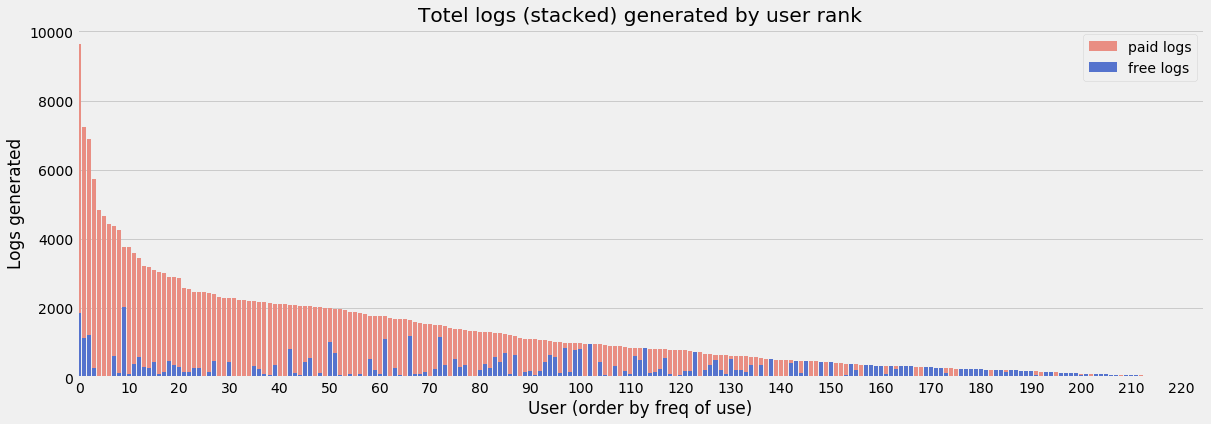

In [24]:
fig, ax = plt.subplots(figsize=(18, 6))

bar_top    = sns.barplot(x=np.arange(1, 226), y=df_users.totLogs.tolist(), color='salmon', label ='paid logs')
bar_bottom = sns.barplot(x=np.arange(1, 226), y=df_users.freeLogs.tolist(), color='royalblue', label='free logs')

ax.set_xlabel('User (order by freq of use)')
ax.set_ylabel('Logs generated')
ax.set_title('Totel logs (stacked) generated by user rank')
ax.set(xticks=np.arange(0, 226, 10), xticklabels=np.arange(0, 226, 10))
plt.legend()

plt.show()

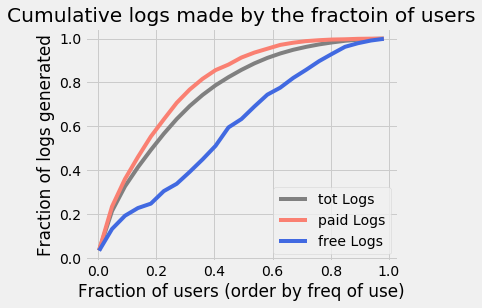

In [25]:
cdf, cdf_paid, cdf_free = [], [], []
for u in range(1, len(df_users)+1, 10):
    cdf.append(np.sum(df_users[:u].totNorm.tolist()))
    cdf_paid.append(np.sum(df_users[:u].paidNorm.tolist()))
    cdf_free.append(np.sum(df_users[:u].freeNorm.tolist()))


fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(np.arange(1, 226, 10)/225., cdf, label='tot Logs', color='gray')
ax.plot(np.arange(1, 226, 10)/225., cdf_paid, label='paid Logs', color='salmon')
ax.plot(np.arange(1, 226, 10)/225., cdf_free, label='free Logs', color='royalblue')
ax.set_xlabel('Fraction of users (order by freq of use)')
ax.set_ylabel('Fraction of logs generated')
ax.set_title('Cumulative logs made by the fractoin of users')
ax.legend();

- Good to see that here we no dominant users. The sample looks general well distributed over users.

- For free logs, the cumulative plot is closer to linear line to normalization one, which means a data less skewed. This is healthy both for modeling and data process when it comes to big data. 
- Pareto's Principle tells a rule of thumb where 80% data usually made by 20% users, while in our case, they are even less skewed. We could be confident to generalize our study in terms of bigger datase.

In [26]:
def showInfoNullColumn(dfspark, col_null, col_show):
    return dfspark.filter(dfspark[col_null].isNull()) \
                .select(dfspark[col_show]) \
                .toPandas() \
                [col_show].value_counts()
    
def showInfoValidColumn(dfspark, col_notnull, col_show):
    return dfspark.filter(dfspark[col_notnull].isNotNull()) \
                .select(dfspark[col_show]) \
                .toPandas() \
                [col_show].value_counts()

In [27]:
showInfoValidColumn(dfspark, 'artist', 'page')

NextSong    228108
Name: page, dtype: int64

In [28]:
showInfoNullColumn(dfspark, 'artist', 'page')[:10]

Home               14457
Thumbs Up          12551
Add to Playlist     6526
Add Friend          4277
Roll Advert         3933
Login               3241
Logout              3226
Thumbs Down         2546
Downgrade           2055
Help                1726
Name: page, dtype: int64

In [29]:
showInfoNullColumn(dfspark, 'artist','auth')

Logged In     49994
Logged Out     8249
Guest            97
Cancelled        52
Name: auth, dtype: int64

In [30]:
showInfoValidColumn(dfspark, 'artist','auth')

Logged In    228108
Name: auth, dtype: int64

In [31]:
showInfoNullColumn(dfspark, 'song','auth')

Logged In     49994
Logged Out     8249
Guest            97
Cancelled        52
Name: auth, dtype: int64

In [32]:
showInfoNullColumn(dfspark, 'song', 'userAgent')[:5]

"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"               4099
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"       3470
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"    3260
Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0                                                      3091
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"    2944
Name: userAgent, dtype: int64

In [33]:
showInfoValidColumn(dfspark, 'song', 'userAgent')[:5]

"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"               18652
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.77.4 (KHTML, like Gecko) Version/7.0.5 Safari/537.77.4"       16141
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"    15188
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"    14404
Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0                                                      13609
Name: userAgent, dtype: int64

In [34]:
showInfoNullColumn(dfspark, 'song', 'status')

200    31704
307    26430
404      258
Name: status, dtype: int64

In [35]:
showInfoValidColumn(dfspark, 'song', 'status')

200    228108
Name: status, dtype: int64

In [36]:
showInfoNullColumn(dfspark, 'lastName', 'song')

Series([], Name: song, dtype: int64)

# Define Churn

Once you've done some preliminary checks, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [37]:
dfspark_valid.select(['userId','page','level','song']).where("page == 'Submit Downgrade'").sort('userId').show()

+------+----------------+-----+----+
|userId|            page|level|song|
+------+----------------+-----+----+
|   100|Submit Downgrade| paid|null|
|100004|Submit Downgrade| paid|null|
|100004|Submit Downgrade| paid|null|
|100008|Submit Downgrade| paid|null|
|100009|Submit Downgrade| paid|null|
|100012|Submit Downgrade| paid|null|
|100015|Submit Downgrade| paid|null|
|100016|Submit Downgrade| paid|null|
|100018|Submit Downgrade| paid|null|
|100018|Submit Downgrade| paid|null|
|100025|Submit Downgrade| paid|null|
|   103|Submit Downgrade| paid|null|
|   109|Submit Downgrade| paid|null|
|    11|Submit Downgrade| paid|null|
|    12|Submit Downgrade| paid|null|
|    13|Submit Downgrade| paid|null|
|    13|Submit Downgrade| paid|null|
|   131|Submit Downgrade| paid|null|
|   131|Submit Downgrade| paid|null|
|   140|Submit Downgrade| paid|null|
+------+----------------+-----+----+
only showing top 20 rows



#### → Let's look through all the activities a user had. 
This is an example the user first as a free user -> then upgrade to a paid user -> later downgrade to a free user again -> and again upgrade as a paid user -> etc, until one day may cancel the service.

⇒ We will want to label the moment when submission events happened on each users. 

In [38]:
dfspark_valid.select(['userId','page','level','song']).where(dfspark_valid.userId == '12').collect()

[Row(userId='12', page='Home', level='free', song=None),
 Row(userId='12', page='NextSong', level='free', song='ReprÃ\x83Â©sente'),
 Row(userId='12', page='NextSong', level='free', song='ReprÃ\x83Â©sente'),
 Row(userId='12', page='Roll Advert', level='free', song=None),
 Row(userId='12', page='NextSong', level='free', song='Cyanide Sweet Tooth Suicide (Album Version)'),
 Row(userId='12', page='Add Friend', level='free', song=None),
 Row(userId='12', page='NextSong', level='free', song='Si tu no estas'),
 Row(userId='12', page='NextSong', level='free', song='MX (LP Version w/ Hidden track "Damone")'),
 Row(userId='12', page='NextSong', level='free', song='Right Here'),
 Row(userId='12', page='NextSong', level='free', song='In The Neck (Album Version)'),
 Row(userId='12', page='NextSong', level='free', song="Why Walk On Water When We've Got Boats (Album Version)"),
 Row(userId='12', page='NextSong', level='free', song='El Hombre Dirigente'),
 Row(userId='12', page='NextSong', level='free

In [39]:
# Churn/Downgrade flags
churn_event = udf(lambda x: 1 if x=='Cancellation Confirmation' else 0, IntegerType())
downgrade_event = udf(lambda x: 1 if x=='Submit Downgrade' else 0, IntegerType())

dfspark_valid = dfspark_valid \
                .withColumn('churn_event', churn_event('page')) \
                .withColumn('downgrade_event', downgrade_event('page')) 

windowval = Window.partitionBy('userId')
dfspark_valid = dfspark_valid \
                .withColumn('churn', max('churn_event').over(windowval)) \
                .withColumn('downgrade', max('downgrade_event').over(windowval))

In [40]:
# If want to explore the data in imperative programming
df = dfspark_valid.toPandas() 
df.to_csv('dfspark_valid.csv')
df.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,sessionId,song,status,ts,userAgent,userId,churn_event,downgrade_event,churn,downgrade
0,Sleeping With Sirens,Logged In,Darianna,F,0,Carpenter,202.97098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,31,Captain Tyin Knots VS Mr Walkway (No Way),200,1539003534000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0
1,Francesca Battistelli,Logged In,Darianna,F,1,Carpenter,196.54485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,31,Beautiful_ Beautiful (Album),200,1539003736000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0
2,Brutha,Logged In,Darianna,F,2,Carpenter,263.13098,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,31,She's Gone,200,1539003932000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0
3,None,Logged In,Darianna,F,3,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,31,None,307,1539003933000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0
4,Josh Ritter,Logged In,Darianna,F,4,Carpenter,316.23791,free,"Bridgeport-Stamford-Norwalk, CT",PUT,...,31,Folk Bloodbath,200,1539004195000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0,0,0,0


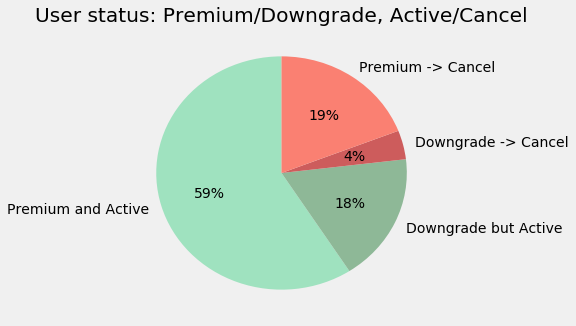

In [41]:
subjects = ['Premium and Active', 'Downgrade but Active', 'Downgrade -> Cancel', 'Premium -> Cancel'] 

data = [133, 40, 9, 43] 
colors = ['#9FE2BF', '#8EB897', '#CD5C5C', '#FA8072'] 
fig, ax = plt.subplots(figsize =(5, 5)) 
plt.pie(data, labels = subjects, colors=colors,  autopct='%1.0f%%', startangle=90) 
ax.set_title('User status: Premium/Downgrade, Active/Cancel')

plt.show() 

# Exploratory Data Analysis


### Some characteristics that may be distinguishable

#### Time related variables: `dfspark_timeInfo`, `dfspark_usage`, `dfspark_usage_change`
1. After the user registrated, how many days have passed before the first use?
2. How many days have passed since the user registrated?
3. Total songs playing time of the user
4. Total sessions of the user has
5. Average song playing time of the user in a session
6. Average number of logs generated of the user per day


#### users' page access activities: `dfspark_usage`, `dfspark_tolerance`
1. songs played
2. thumbs up
3. thumbs down
4. songs have been added to the playlist
5. friends added
6. page error encountered
7. roll Advert have been played

#### users' profiles: `dfspark_persona`
1. gender
2. location state
3. playing device
4. the proportion of "paid-log" over the "all-log" of each user 


#### Time related variables: `dfspark_timeInfo` 

In [42]:
# 'Use' means the users listened to music
lastUse_event = dfspark_valid \
                .where(dfspark_valid.song.isNotNull()) \
                .groupby(['userId', 'churn', 'downgrade']).agg(max('ts'))

firstUse_event = dfspark_valid \
                .where(dfspark_valid.song.isNotNull()) \
                .groupby(['userId', 'churn', 'downgrade']).agg(min('ts'))

registration_event = dfspark_valid \
                .groupby(['userId', 'churn', 'downgrade']).agg(min('registration'))

# Merge dataFrames
dfspark_timeInfo = lastUse_event \
                    .join(firstUse_event, on=['userId', 'churn', 'downgrade'], how='inner') \
                    .join(registration_event, on=['userId', 'churn', 'downgrade'], how='inner')

# Apply function to convert the timestamps
time_convertor = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

dfspark_timeInfo = dfspark_timeInfo.withColumn('lastUse_time', time_convertor('max(ts)'))
dfspark_timeInfo = dfspark_timeInfo.withColumn('firstUse_time', time_convertor('min(ts)'))
dfspark_timeInfo = dfspark_timeInfo.withColumn('registration_time', time_convertor('min(registration)'))

# Prepare the final dataFrame
dfspark_timeInfo = dfspark_timeInfo \
                    .withColumn('firstUseDay', f.datediff(f.col('firstUse_time'), f.col('registration_time'))) \
                    .withColumn('spanUseDay', f.datediff(f.col('lastUse_time'), f.col('firstUse_time'))) \
                    .withColumn('totDay', f.datediff(f.col('lastUse_time'), f.col('registration_time')))


In [43]:
dfspark_timeInfo = dfspark_timeInfo.select(['userId','churn','downgrade',
                                            'firstUseDay','spanUseDay','totDay'])

dfspark_timeInfo.show()

+------+-----+---------+-----------+----------+------+
|userId|churn|downgrade|firstUseDay|spanUseDay|totDay|
+------+-----+---------+-----------+----------+------+
|   109|    0|        1|         48|        40|    88|
|    89|    0|        0|         38|        31|    69|
|300016|    0|        0|         49|        52|   101|
|300011|    0|        1|          1|        61|    62|
|    68|    0|        0|         56|        44|   100|
|   100|    0|        1|          6|        59|    65|
|   128|    0|        0|         39|        56|    95|
|300015|    0|        1|        111|        60|   171|
|200018|    1|        0|         22|        27|    49|
|    67|    0|        0|         91|        48|   139|
|    20|    0|        1|         20|        57|    77|
|    29|    1|        0|         16|        44|    60|
|    66|    0|        0|         70|        56|   126|
|    49|    0|        1|         50|        57|   107|
|   113|    0|        0|         63|        60|   123|
|   137|  

In [44]:
print("Data Shape = (", dfspark_timeInfo.count(), ",", len(dfspark_timeInfo.columns), ")")

Data Shape = ( 225 , 6 )


In [45]:
df_timeInfo = dfspark_timeInfo.toPandas()
df_timeInfo.to_csv('timeInfo.csv')
df_timeInfo.head()

,userId,churn,downgrade,firstUseDay,spanUseDay,totDay
0,109,0,1,48,40,88
1,89,0,0,38,31,69
2,300016,0,0,49,52,101
3,300011,0,1,1,61,62
4,68,0,0,56,44,100


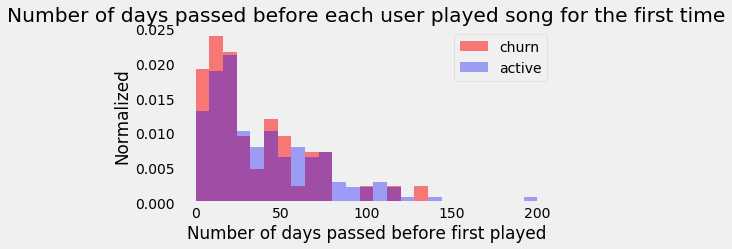

In [46]:
fig, ax = plt.subplots(figsize=(6,3))
plt.style.use('seaborn-muted')
plt.grid(False)

plt.hist(df_timeInfo[df_timeInfo['churn']==1]["firstUseDay"], bins=25, range=[0, 200], density=1, alpha=0.5, color='r', label='churn')
plt.hist(df_timeInfo[df_timeInfo['churn']==0]["firstUseDay"], bins=25, range=[0, 200], density=1, alpha=0.35, color='b', label='active')
plt.legend()
ax.set_title('Number of days passed before each user played song for the first time')
ax.set_xlabel('Number of days passed before first played')
ax.set_ylabel('Normalized');

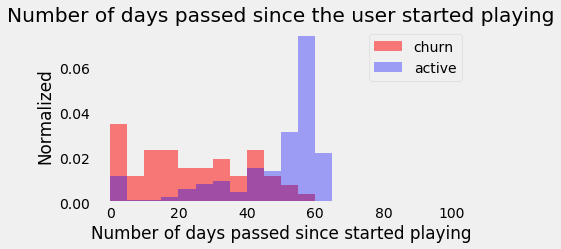

In [47]:
fig, ax = plt.subplots(figsize=(6,3))
plt.style.use('seaborn-muted')
plt.grid(False)

plt.hist(df_timeInfo[df_timeInfo['churn']==1]["spanUseDay"], bins=20, range=[0, 100], density=1, alpha=0.5, color='r', label='churn')
plt.hist(df_timeInfo[df_timeInfo['churn']==0]["spanUseDay"], bins=20, range=[0, 100], density=1, alpha=0.35, color='b', label='active')
plt.legend()
ax.set_title('Number of days passed since the user started playing')
ax.set_xlabel('Number of days passed since started playing')
ax.set_ylabel('Normalized');

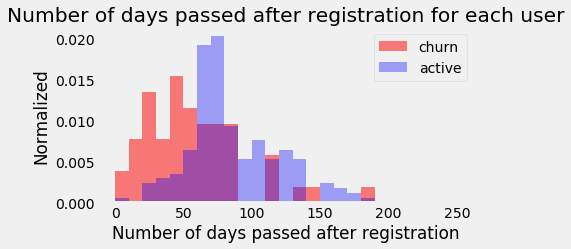

In [48]:
fig, ax = plt.subplots(figsize=(6,3))
plt.style.use('seaborn-muted')
plt.grid(False)

plt.hist(df_timeInfo[df_timeInfo['churn']==1]["totDay"], bins=25, range=[0, 250], density=1, alpha=0.5, color='r', label='churn')
plt.hist(df_timeInfo[df_timeInfo['churn']==0]["totDay"], bins=25, range=[0, 250], density=1, alpha=0.35, color='b', label='active')
plt.legend()
ax.set_title('Number of days passed after registration for each user')
ax.set_xlabel('Number of days passed after registration')
ax.set_ylabel('Normalized');

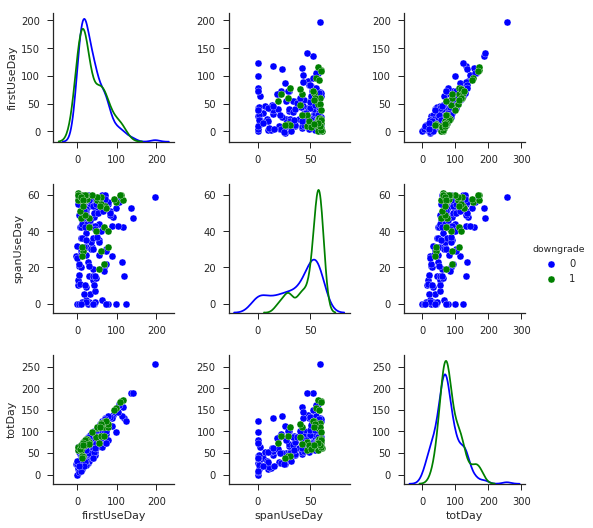

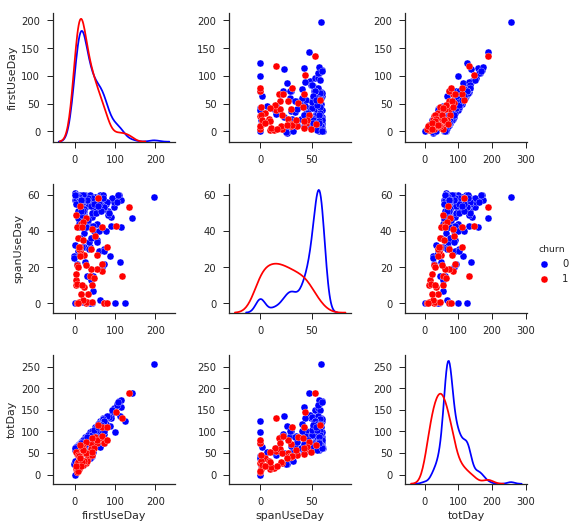

In [49]:
sns.set(style="ticks")
df = df_timeInfo[['firstUseDay','spanUseDay','totDay','downgrade','churn']]

x_vars=['firstUseDay','spanUseDay','totDay']
y_vars=['firstUseDay','spanUseDay','totDay']
    
sns.pairplot(df, x_vars=x_vars, y_vars=y_vars, hue='downgrade', diag_kind="kde", palette={1:'g', 0:'b'})
sns.pairplot(df, x_vars=x_vars, y_vars=y_vars, hue='churn', diag_kind="kde", palette={1:'r', 0:'b'});

#### Time related variables: `dfspark_usage` 

In [50]:
totUseSession = dfspark_valid \
                .groupby(['userId', 'churn', 'downgrade']).agg(countDistinct('sessionId')) \
                .withColumnRenamed('count(DISTINCT sessionId)', 'totUseSession')

totUseLength = dfspark_valid \
                .groupby(['userId', 'churn', 'downgrade']).agg(sum('length')) \
                .withColumnRenamed('sum(length)', 'totUseLength')

logs = dfspark_valid \
                .groupby(['userId', 'churn', 'downgrade']).agg(count('ts')) \
                .withColumnRenamed('count(ts)', 'totLogs')

# Merge dataFrames
dfspark_usage = dfspark_timeInfo \
                .join(totUseSession, on=['userId', 'churn', 'downgrade'], how='inner') \
                .join(totUseLength, on=['userId', 'churn', 'downgrade'], how='inner') \
                .join(logs, on=['userId', 'churn', 'downgrade'], how='inner')

# Prepare the final dataFrame
dfspark_usage = dfspark_usage \
                .withColumn('totUseMinute', round(f.col('totUseLength')/60.)) \
                .withColumn('avgUseMinute', round(f.col('totUseLength')/60./f.col('totUseSession')))  \
                .withColumn('avgLogsDay', round(f.col('totLogs')/f.col('totDay')))


In [51]:
dfspark_usage = dfspark_usage.select(['userId','churn','downgrade',
                                      'totDay','totUseSession',
                                      'totUseMinute','avgUseMinute', 
                                      'totLogs','avgLogsDay'])
dfspark_usage.show()

+------+-----+---------+------+-------------+------------+------------+-------+----------+
|userId|churn|downgrade|totDay|totUseSession|totUseMinute|avgUseMinute|totLogs|avgLogsDay|
+------+-----+---------+------+-------------+------------+------------+-------+----------+
|   109|    0|        1|    88|           12|      2983.0|       249.0|    861|      10.0|
|    89|    0|        0|    69|            5|      2763.0|       553.0|    801|      12.0|
|300016|    0|        0|   101|           13|      2414.0|       186.0|    735|       7.0|
|300011|    0|        1|    62|           76|     19161.0|       252.0|   5732|      92.0|
|    68|    0|        0|   100|            2|       118.0|        59.0|     48|       0.0|
|   100|    0|        1|    65|           35|     11215.0|       320.0|   3214|      49.0|
|   128|    0|        0|    95|           17|      7157.0|       421.0|   2067|      22.0|
|300015|    0|        1|   171|           33|     10321.0|       313.0|   3051|      18.0|

In [52]:
print("Data Shape = (", dfspark_usage.count(), ",", len(dfspark_usage.columns), ")")

Data Shape = ( 225 , 9 )


In [53]:
df_usage = dfspark_usage.toPandas()
df_usage.to_csv('usage.csv')
df_usage.head()

,userId,churn,downgrade,totDay,totUseSession,totUseMinute,avgUseMinute,totLogs,avgLogsDay
0,109,0,1,88,12,2983.0,249.0,861,10.0
1,89,0,0,69,5,2763.0,553.0,801,12.0
2,300016,0,0,101,13,2414.0,186.0,735,7.0
3,300011,0,1,62,76,19161.0,252.0,5732,92.0
4,68,0,0,100,2,118.0,59.0,48,0.0


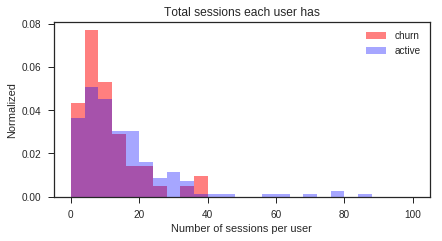

In [54]:
fig, ax = plt.subplots(figsize=(6,3))
plt.style.use('seaborn-whitegrid')
plt.grid(False)

plt.hist(df_usage[df_usage['churn']==1]["totUseSession"], bins=25, range=[0, 100], density=1, alpha=0.5, color='r', label='churn')
plt.hist(df_usage[df_usage['churn']==0]["totUseSession"], bins=25, range=[0, 100], density=1, alpha=0.35, color='b', label='active')
plt.legend()
ax.set_title('Total sessions each user has')
ax.set_xlabel('Number of sessions per user')
ax.set_ylabel('Normalized');

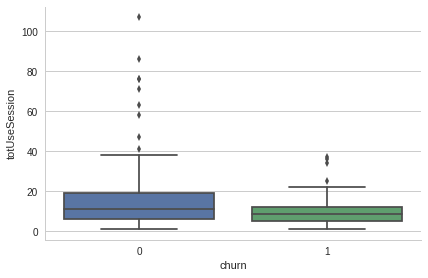

In [55]:
#plt.style.use('fivethirtyeight')
ax = sns.boxplot(data=df_usage, x='churn', y='totUseSession')
sns.despine(ax=ax)

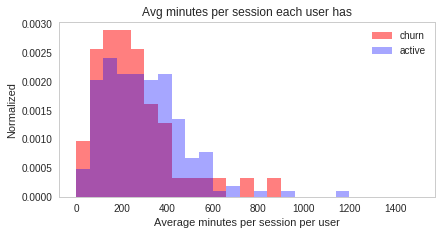

In [56]:
fig, ax = plt.subplots(figsize=(6,3))
plt.style.use('seaborn-whitegrid')
plt.grid(False)

plt.hist(df_usage[df_usage['churn']==1]["avgUseMinute"], bins=25, range=[0, 1500], density=1, alpha=0.5, color='r', label='churn')
plt.hist(df_usage[df_usage['churn']==0]["avgUseMinute"], bins=25, range=[0, 1500], density=1, alpha=0.35, color='b', label='active')
plt.legend()
ax.set_title('Avg minutes per session each user has')
ax.set_xlabel('Average minutes per session per user')
ax.set_ylabel('Normalized');

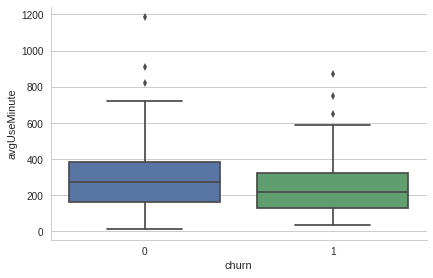

In [57]:
#plt.style.use('fivethirtyeight')
ax = sns.boxplot(data=df_usage, x='churn', y='avgUseMinute')
sns.despine(ax=ax)

/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:747: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/opt/conda/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


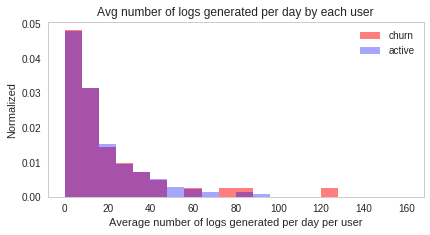

In [58]:
fig, ax = plt.subplots(figsize=(6,3))
plt.style.use('seaborn-whitegrid')
plt.grid(False)

plt.hist(df_usage[df_usage['churn']==1]["avgLogsDay"], bins=20, range=[0, 160], density=1, alpha=0.5, color='r', label='churn')
plt.hist(df_usage[df_usage['churn']==0]["avgLogsDay"], bins=20, range=[0, 160], density=1, alpha=0.35, color='b', label='active')
plt.legend()
ax.set_title('Avg number of logs generated per day by each user')
ax.set_xlabel('Average number of logs generated per day per user')
ax.set_ylabel('Normalized');

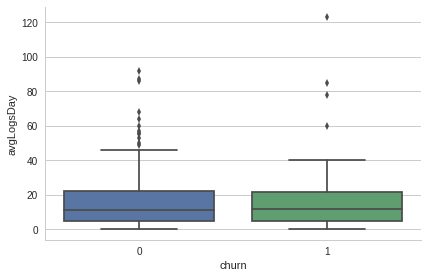

In [59]:
#plt.style.use('fivethirtyeight')
ax = sns.boxplot(data=df_usage, x='churn', y='avgLogsDay')
sns.despine(ax=ax)

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


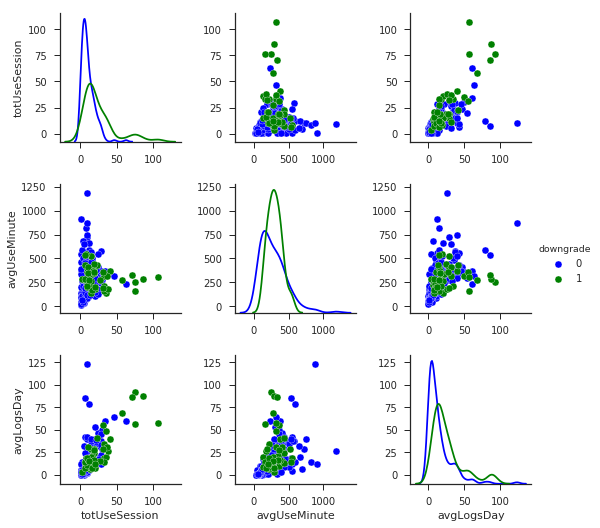

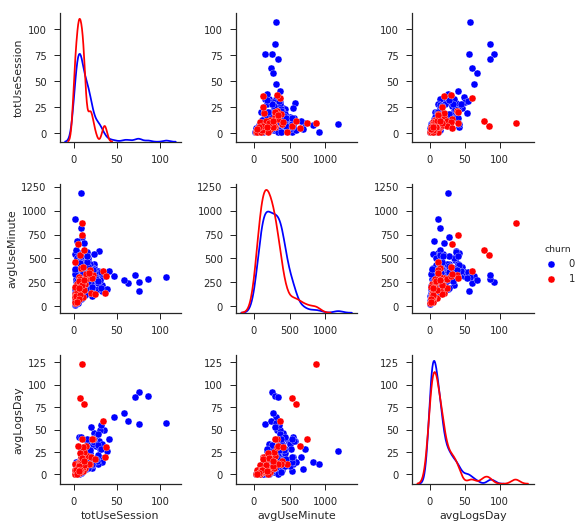

In [60]:
sns.set(style="ticks")
df = df_usage[['totUseSession', 'avgUseMinute','avgLogsDay','downgrade','churn']]

x_vars=['totUseSession', 'avgUseMinute','avgLogsDay']
y_vars=['totUseSession', 'avgUseMinute','avgLogsDay']
    
sns.pairplot(df, x_vars=x_vars, y_vars=y_vars, hue='downgrade', diag_kind="kde", palette={1:'g', 0:'b'})
sns.pairplot(df, x_vars=x_vars, y_vars=y_vars, hue='churn', diag_kind="kde", palette={1:'r', 0:'b'});

#### Time related variables: `dfspark_usage_change` 

In [61]:
# UseLength in a session
totUseLength = dfspark_valid \
                .groupby(['userId', 'churn', 'downgrade','sessionId']).agg(sum('length')) \
                .withColumnRenamed('sum(length)', 'totUseLength')

# Porcess the table just got up above
minUseLength = totUseLength \
                .groupby(['userId', 'churn', 'downgrade']).agg(min('totUseLength')) \
                .withColumnRenamed('min(totUseLength)', 'minUseLength')

maxUseLength = totUseLength \
                .groupby(['userId', 'churn', 'downgrade']).agg(max('totUseLength')) \
                .withColumnRenamed('max(totUseLength)', 'maxUseLength')

stdUseLength = totUseLength \
                .groupby(['userId', 'churn', 'downgrade']).agg(stddev('totUseLength')) \
                .withColumnRenamed('stddev_samp(totUseLength)', 'stdUseLength')

                        
# Merge dataFrame with info from `dfspark_usage`
dfspark_usage_change = dfspark_usage \
                .join(minUseLength, on=['userId', 'churn', 'downgrade'], how='inner') \
                .join(maxUseLength, on=['userId', 'churn', 'downgrade'], how='inner') \
                .join(stdUseLength, on=['userId', 'churn', 'downgrade'], how='inner')
                
    

dfspark_usage_change = dfspark_usage_change \
                .withColumn('minUseMinute', round(f.col('minUseLength')/60., 2)) \
                .withColumn('maxUseMinute', round(f.col('maxUseLength')/60., 2)) \
                .withColumn('stdUseMinute', round(f.col('stdUseLength')/60., 2)) \
                .withColumn('rangeUseMinute', round((f.col('maxUseLength')-f.col('minUseLength'))/60., 2)) 


In [62]:
dfspark_usage_change = dfspark_usage_change.select(['userId','churn','downgrade',
                                                    'stdUseMinute','minUseMinute','maxUseMinute',
                                                    'rangeUseMinute'])
dfspark_usage_change.show()

+------+-----+---------+------------+------------+------------+--------------+
|userId|churn|downgrade|stdUseMinute|minUseMinute|maxUseMinute|rangeUseMinute|
+------+-----+---------+------------+------------+------------+--------------+
|   109|    0|        1|      289.32|       23.84|      962.08|        938.24|
|    89|    0|        0|      697.68|       53.25|     1711.01|       1657.76|
|300016|    0|        0|      149.57|       33.28|      479.37|        446.09|
|300011|    0|        1|      280.73|         3.2|     1384.87|       1381.67|
|    68|    0|        0|       45.53|        26.8|       91.19|         64.39|
|   100|    0|        1|      308.28|        6.86|      1025.7|       1018.85|
|   128|    0|        0|      475.57|       38.76|     1826.37|       1787.61|
|300015|    0|        1|       292.0|       22.61|     1238.02|       1215.41|
|200018|    1|        0|      131.33|       14.86|      377.59|        362.73|
|    67|    0|        0|      303.26|       49.24|  

In [63]:
dfspark_usage_change = dfspark_usage_change.na.fill(value=0, subset=['stdUseMinute','minUseMinute','maxUseMinute','rangeUseMinute'])
dfspark_usage_change.show()

+------+-----+---------+------------+------------+------------+--------------+
|userId|churn|downgrade|stdUseMinute|minUseMinute|maxUseMinute|rangeUseMinute|
+------+-----+---------+------------+------------+------------+--------------+
|   109|    0|        1|      289.32|       23.84|      962.08|        938.24|
|    89|    0|        0|      697.68|       53.25|     1711.01|       1657.76|
|300016|    0|        0|      149.57|       33.28|      479.37|        446.09|
|300011|    0|        1|      280.73|         3.2|     1384.87|       1381.67|
|    68|    0|        0|       45.53|        26.8|       91.19|         64.39|
|   100|    0|        1|      308.28|        6.86|      1025.7|       1018.85|
|   128|    0|        0|      475.57|       38.76|     1826.37|       1787.61|
|300015|    0|        1|       292.0|       22.61|     1238.02|       1215.41|
|200018|    1|        0|      131.33|       14.86|      377.59|        362.73|
|    67|    0|        0|      303.26|       49.24|  

In [64]:
print("Data Shape = (", dfspark_usage_change.count(), ",", len(dfspark_usage_change.columns), ")")

Data Shape = ( 225 , 7 )


In [65]:
df_usage_change = dfspark_usage_change.toPandas()
df_usage_change.to_csv('usage_change.csv')
df_usage_change.head()

,userId,churn,downgrade,stdUseMinute,minUseMinute,maxUseMinute,rangeUseMinute
0,109,0,1,289.32,23.84,962.08,938.24
1,89,0,0,697.68,53.25,1711.01,1657.76
2,300016,0,0,149.57,33.28,479.37,446.09
3,300011,0,1,280.73,3.20,1384.87,1381.67
4,68,0,0,45.53,26.80,91.19,64.39


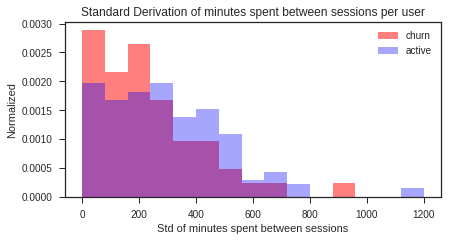

In [66]:
fig, ax = plt.subplots(figsize=(6,3))
plt.style.use('seaborn-whitegrid')
plt.grid(False)

plt.hist(df_usage_change[df_usage_change['churn']==1]["stdUseMinute"], bins=15, range=[0, 1200], density=1, alpha=0.5, color='r', label='churn')
plt.hist(df_usage_change[df_usage_change['churn']==0]["stdUseMinute"], bins=15, range=[0, 1200], density=1, alpha=0.35, color='b', label='active')
plt.legend()
ax.set_title('Standard Derivation of minutes spent between sessions per user')
ax.set_xlabel('Std of minutes spent between sessions')
ax.set_ylabel('Normalized');

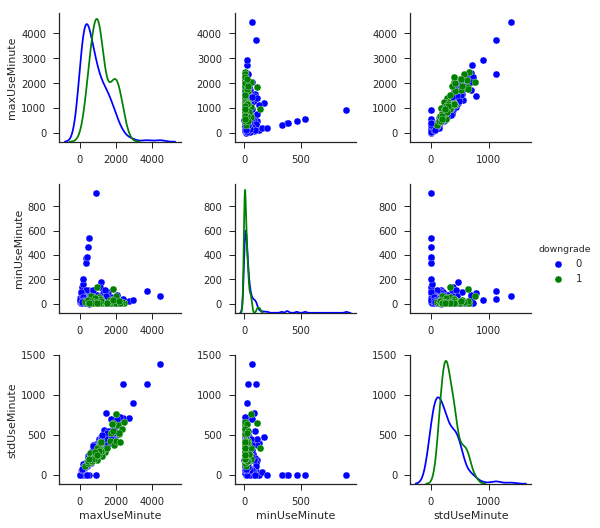

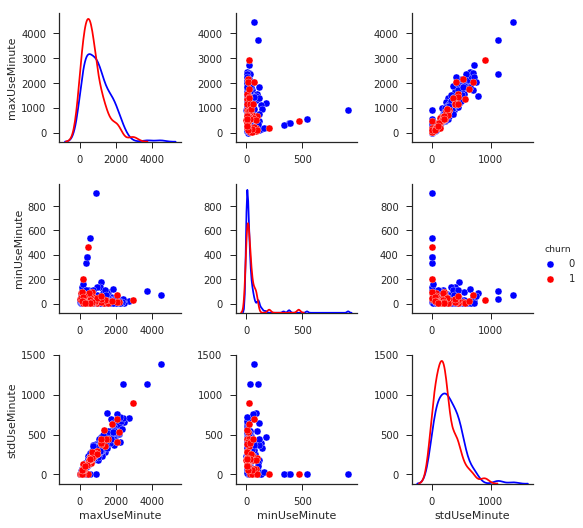

In [67]:
sns.set(style="ticks")
df = df_usage_change[['maxUseMinute','minUseMinute','stdUseMinute','downgrade', 'churn']]

x_vars=['maxUseMinute','minUseMinute','stdUseMinute']
y_vars=['maxUseMinute','minUseMinute','stdUseMinute']
    
sns.pairplot(df, x_vars=x_vars, y_vars=y_vars, hue='downgrade', diag_kind="kde", palette={1:'g', 0:'b'})
sns.pairplot(df, x_vars=x_vars, y_vars=y_vars, hue='churn', diag_kind="kde", palette={1:'r', 0:'b'});

#### Time related variables: `dfspark_page` 

In [68]:
nextsong = dfspark_valid \
                .where(dfspark_valid.page == 'NextSong') \
                .groupby(['userId','churn','downgrade']).agg(count('page')) \
                .withColumnRenamed('count(page)', 'totNextSong')

thumbsup = dfspark_valid \
                .where(dfspark_valid.page == 'Thumbs Up') \
                .groupby(['userId','churn','downgrade']).agg(count('page')) \
                .withColumnRenamed('count(page)', 'totThumbsUp')

thumbsdown = dfspark_valid \
                .where(dfspark_valid.page == 'Thumbs Down') \
                .groupby(['userId','churn','downgrade']).agg(count('page')) \
                .withColumnRenamed('count(page)', 'totThumbsDown')

add2playlist = dfspark_valid \
                .where(dfspark_valid.page == 'Add to Playlist') \
                .groupby(['userId','churn','downgrade']).agg(count('page')) \
                .withColumnRenamed('count(page)', 'totAddPlaylist')

addfriend = dfspark_valid \
                .where(dfspark_valid.page == 'Add Friend') \
                .groupby(['userId','churn','downgrade']).agg(count('page')) \
                .withColumnRenamed('count(page)', 'totAddFriend')


# Merge dataFrames
# Notice: not every user has each kind of page activities, how='outer'
dfspark_page = nextsong \
                .join(thumbsup, on=['userId', 'churn', 'downgrade'], how='outer') \
                .join(thumbsdown, on=['userId', 'churn', 'downgrade'], how='outer') \
                .join(add2playlist, on=['userId', 'churn', 'downgrade'], how='outer') \
                .join(addfriend, on=['userId', 'churn', 'downgrade'], how='outer') 


dfspark_page = dfspark_page \
            .withColumn('actsAll', f.expr('totThumbsUp + totThumbsDown + totAddPlaylist + totAddFriend')) \
            .withColumn('actsPartition', f.expr('totThumbsUp + totAddPlaylist + totAddFriend'))

In [69]:
dfspark_page = dfspark_page.select(['userId','churn','downgrade',
                                    'totNextSong','totThumbsUp','totThumbsDown','totAddPlaylist','totAddFriend',
                                    'actsAll', 'actsPartition'])
dfspark_page.show()

+------+-----+---------+-----------+-----------+-------------+--------------+------------+-------+-------------+
|userId|churn|downgrade|totNextSong|totThumbsUp|totThumbsDown|totAddPlaylist|totAddFriend|actsAll|actsPartition|
+------+-----+---------+-----------+-----------+-------------+--------------+------------+-------+-------------+
|   109|    0|        1|        717|         23|            5|            16|          12|     56|           51|
|    89|    0|        0|        667|         30|            6|            12|          14|     62|           56|
|300016|    0|        0|        583|         56|            4|            26|          11|     97|           93|
|300011|    0|        1|       4619|        437|           41|           146|          93|    717|          676|
|    68|    0|        0|         29|          2|         null|          null|           7|   null|         null|
|   100|    0|        1|       2682|        148|           27|            61|          49|    28

In [70]:
dfspark_page = dfspark_page.na.fill(value=0, subset=['totNextSong','totThumbsUp','totThumbsDown','totAddPlaylist','totAddFriend','acts'])
dfspark_page.show()

+------+-----+---------+-----------+-----------+-------------+--------------+------------+-------+-------------+
|userId|churn|downgrade|totNextSong|totThumbsUp|totThumbsDown|totAddPlaylist|totAddFriend|actsAll|actsPartition|
+------+-----+---------+-----------+-----------+-------------+--------------+------------+-------+-------------+
|   109|    0|        1|        717|         23|            5|            16|          12|     56|           51|
|    89|    0|        0|        667|         30|            6|            12|          14|     62|           56|
|300016|    0|        0|        583|         56|            4|            26|          11|     97|           93|
|300011|    0|        1|       4619|        437|           41|           146|          93|    717|          676|
|    68|    0|        0|         29|          2|            0|             0|           7|   null|         null|
|   100|    0|        1|       2682|        148|           27|            61|          49|    28

In [71]:
print("Data Shape = (", dfspark_page.count(), ",", len(dfspark_page.columns), ")")

Data Shape = ( 225 , 10 )


In [72]:
df_page = dfspark_page.toPandas()
df_page.to_csv('page.csv')
df_page.head()

,userId,churn,downgrade,totNextSong,totThumbsUp,totThumbsDown,totAddPlaylist,totAddFriend,actsAll,actsPartition
0,109,0,1,717,23,5,16,12,56.0,51.0
1,89,0,0,667,30,6,12,14,62.0,56.0
2,300016,0,0,583,56,4,26,11,97.0,93.0
3,300011,0,1,4619,437,41,146,93,717.0,676.0
4,68,0,0,29,2,0,0,7,NaN,NaN


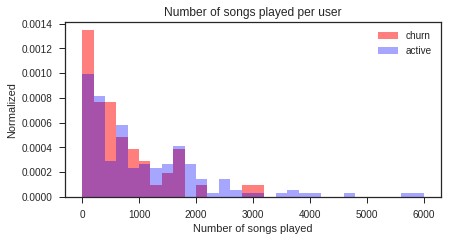

In [73]:
fig, ax = plt.subplots(figsize=(6,3))
plt.style.use('seaborn-whitegrid')
plt.grid(False)

plt.hist(df_page[df_page['churn']==1]["totNextSong"], bins=30, range=[0, 6000], density=1, alpha=0.5, color='r', label='churn')
plt.hist(df_page[df_page['churn']==0]["totNextSong"], bins=30, range=[0, 6000], density=1, alpha=0.35, color='b', label='active')
plt.legend()
ax.set_title('Number of songs played per user')
ax.set_xlabel('Number of songs played')
ax.set_ylabel('Normalized');

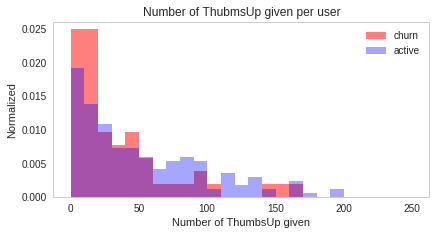

In [74]:
fig, ax = plt.subplots(figsize=(6,3))
plt.style.use('seaborn-whitegrid')
plt.grid(False)

ax.set_ylim(0,0.026)
plt.hist(df_page[df_page['churn']==1]["totThumbsUp"], bins=25, range=[0, 250], density=1, alpha=0.5, color='r', label='churn')
plt.hist(df_page[df_page['churn']==0]["totThumbsUp"], bins=25, range=[0, 250], density=1, alpha=0.35, color='b', label='active')
plt.legend()
ax.set_title('Number of ThubmsUp given per user')
ax.set_xlabel('Number of ThumbsUp given')
ax.set_ylabel('Normalized');

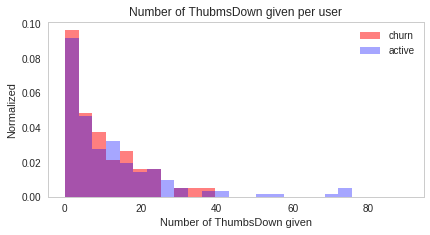

In [75]:
fig, ax = plt.subplots(figsize=(6,3))
plt.style.use('seaborn-whitegrid')
plt.grid(False)

plt.hist(df_page[df_page['churn']==1]["totThumbsDown"], bins=25, range=[0, 90], density=1, alpha=0.5, color='r', label='churn')
plt.hist(df_page[df_page['churn']==0]["totThumbsDown"], bins=25, range=[0, 90], density=1, alpha=0.35, color='b', label='active')
plt.legend()
ax.set_title('Number of ThubmsDown given per user')
ax.set_xlabel('Number of ThumbsDown given')
ax.set_ylabel('Normalized');

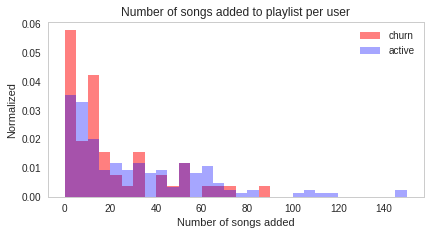

In [76]:
fig, ax = plt.subplots(figsize=(6,3))
plt.style.use('seaborn-whitegrid')
plt.grid(False)

plt.hist(df_page[df_page['churn']==1]["totAddPlaylist"], bins=30, range=[0, 150], density=1, alpha=0.5, color='r', label='churn')
plt.hist(df_page[df_page['churn']==0]["totAddPlaylist"], bins=30, range=[0, 150], density=1, alpha=0.35, color='b', label='active')
plt.legend()
ax.set_title('Number of songs added to playlist per user')
ax.set_xlabel('Number of songs added')
ax.set_ylabel('Normalized');

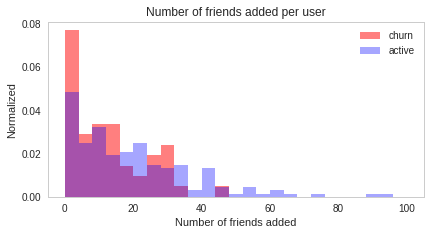

In [77]:
fig, ax = plt.subplots(figsize=(6,3))
plt.style.use('seaborn-whitegrid')
plt.grid(False)

plt.hist(df_page[df_page['churn']==1]["totAddFriend"], bins=25, range=[0, 100], density=1, alpha=0.5, color='r', label='churn')
plt.hist(df_page[df_page['churn']==0]["totAddFriend"], bins=25, range=[0, 100], density=1, alpha=0.35, color='b', label='active')
plt.legend()
ax.set_title('Number of friends added per user')
ax.set_xlabel('Number of friends added')
ax.set_ylabel('Normalized');

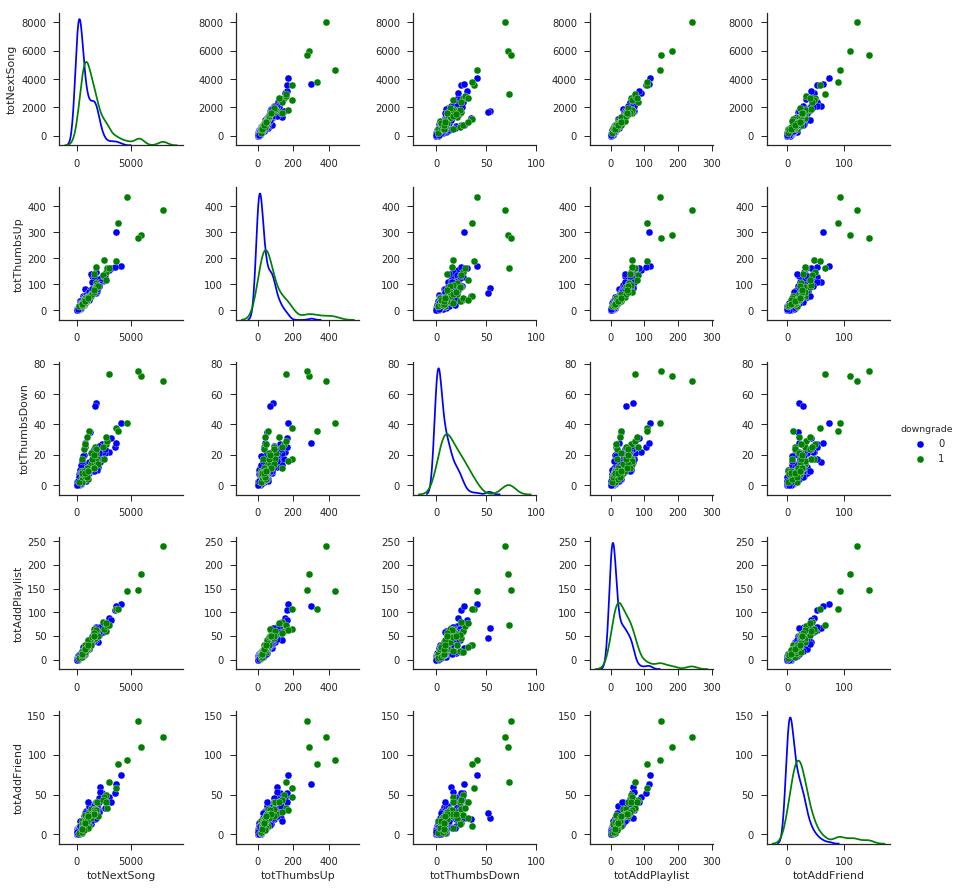

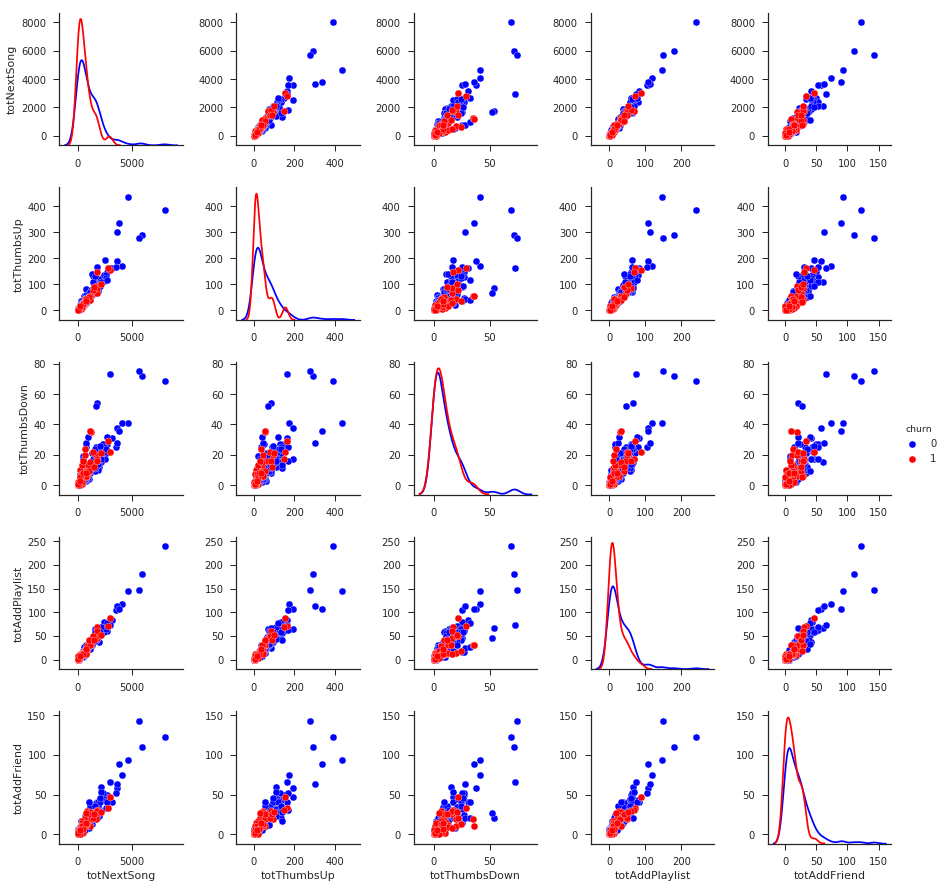

In [78]:
sns.set(style="ticks")
df = df_page[['totNextSong','totThumbsUp','totThumbsDown','totAddPlaylist','totAddFriend','downgrade', 'churn']]

x_vars=['totNextSong','totThumbsUp','totThumbsDown','totAddPlaylist','totAddFriend']
y_vars=['totNextSong','totThumbsUp','totThumbsDown','totAddPlaylist','totAddFriend']
    
sns.pairplot(df, x_vars=x_vars, y_vars=y_vars, hue='downgrade', diag_kind="kde", palette={1:'g', 0:'b'})
sns.pairplot(df, x_vars=x_vars, y_vars=y_vars, hue='churn', diag_kind="kde", palette={1:'r', 0:'b'});

#### Time related variables: `dfspark_tolerance` 

In [79]:
error = dfspark_valid \
                .where(dfspark_valid.page == 'Error') \
                .groupby(['userId','churn','downgrade','sessionId']).agg(count('page')) \
                .withColumnRenamed('count(page)', 'totError')

ad = dfspark_valid \
                .where(dfspark_valid.page == 'Roll Advert') \
                .groupby(['userId','churn','downgrade','sessionId']).agg(count('page')) \
                .withColumnRenamed('count(page)', 'totAdvert')

# Merge dataFrames
# Notice: not every user encountered the cases, how='outer'
dfspark_tolerance = error.join(ad, on=['userId', 'churn', 'downgrade'], how='outer') 


# process the table we just got from above
maxerror = dfspark_tolerance \
                .groupby(['userId','churn','downgrade']).agg(max('totError')) \
                .withColumnRenamed('max(totError)', 'maxError')

maxad = dfspark_tolerance \
                .groupby(['userId','churn','downgrade']).agg(max('totAdvert')) \
                .withColumnRenamed('max(totAdvert)', 'maxAdvert')

# Merge dataFrames
# Notice: not every user encountered error and had listened advertisment, how='outer'
dfspark_maxtolerance = maxerror.join(maxad, on=['userId', 'churn', 'downgrade'], how='outer') 

In [80]:
dfspark_maxtolerance = dfspark_maxtolerance.select(['userId','churn','downgrade',
                                                    'maxError', 'maxAdvert']) 
dfspark_maxtolerance.show()

+------+-----+---------+--------+---------+
|userId|churn|downgrade|maxError|maxAdvert|
+------+-----+---------+--------+---------+
|   109|    0|        1|    null|        3|
|    89|    0|        0|    null|       11|
|300016|    0|        0|       1|        2|
|300011|    0|        1|       1|        4|
|    68|    0|        0|    null|        3|
|   100|    0|        1|       1|       11|
|   128|    0|        0|       1|        6|
|300015|    0|        1|       2|        3|
|200018|    1|        0|    null|        7|
|    67|    0|        0|    null|        9|
|    20|    0|        1|       1|        8|
|    29|    1|        0|    null|        6|
|    66|    0|        0|    null|        8|
|    49|    0|        1|       3|        7|
|   113|    0|        0|       1|        1|
|   137|    0|        0|    null|        7|
|   124|    0|        0|       2|        2|
|300007|    1|        0|    null|        2|
|    45|    0|        0|    null|        5|
|    71|    0|        0|       1

In [81]:
dfspark_maxtolerance = dfspark_maxtolerance.na.fill(value=0, subset=['maxError', 'maxAdvert'])
dfspark_maxtolerance.show()

+------+-----+---------+--------+---------+
|userId|churn|downgrade|maxError|maxAdvert|
+------+-----+---------+--------+---------+
|   109|    0|        1|       0|        3|
|    89|    0|        0|       0|       11|
|300016|    0|        0|       1|        2|
|300011|    0|        1|       1|        4|
|    68|    0|        0|       0|        3|
|   100|    0|        1|       1|       11|
|   128|    0|        0|       1|        6|
|300015|    0|        1|       2|        3|
|200018|    1|        0|       0|        7|
|    67|    0|        0|       0|        9|
|    20|    0|        1|       1|        8|
|    29|    1|        0|       0|        6|
|    66|    0|        0|       0|        8|
|    49|    0|        1|       3|        7|
|   113|    0|        0|       1|        1|
|   137|    0|        0|       0|        7|
|   124|    0|        0|       2|        2|
|300007|    1|        0|       0|        2|
|    45|    0|        0|       0|        5|
|    71|    0|        0|       1

In [82]:
print("Data Shape = (", dfspark_maxtolerance.count(), ",", len(dfspark_maxtolerance.columns), ")")

Data Shape = ( 214 , 5 )


In [83]:
df_maxtolerance = dfspark_maxtolerance.toPandas()
df_maxtolerance.to_csv('maxtoleranbce.csv')
df_maxtolerance.head()

,userId,churn,downgrade,maxError,maxAdvert
0,109,0,1,0,3
1,89,0,0,0,11
2,300016,0,0,1,2
3,300011,0,1,1,4
4,68,0,0,0,3


In [84]:
plt.style.use('fivethirtyeight')

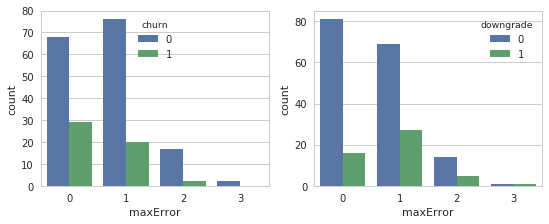

In [85]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1,2, figsize=(8,3))
sns.countplot(data=df_maxtolerance, x="maxError", hue='churn', ax=axes[0])
sns.countplot(data=df_maxtolerance, x="maxError", hue='downgrade', ax=axes[1]);

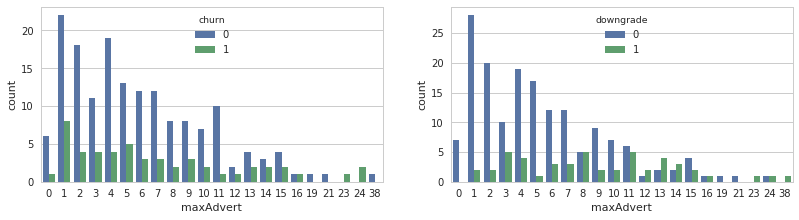

In [86]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1,2, figsize=(12,3))
sns.countplot(data=df_maxtolerance, x="maxAdvert", hue='churn', ax=axes[0])
sns.countplot(data=df_maxtolerance, x="maxAdvert", hue='downgrade', ax=axes[1]);

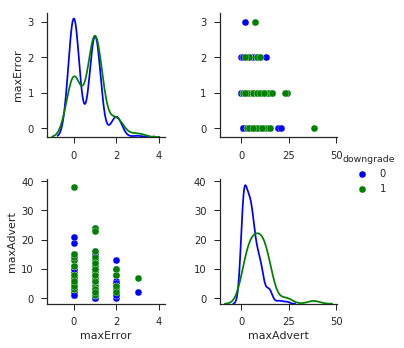

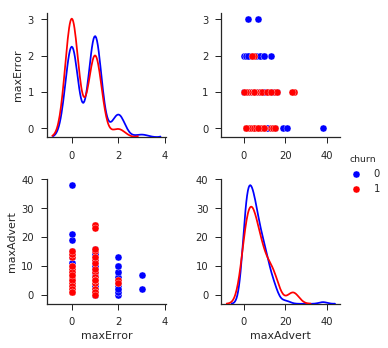

In [87]:
sns.set(style="ticks")
df = df_maxtolerance[['maxError','maxAdvert','downgrade', 'churn']]

x_vars=['maxError','maxAdvert']
y_vars=['maxError','maxAdvert']
    
sns.pairplot(df, x_vars=x_vars, y_vars=y_vars, hue='downgrade', diag_kind="kde", palette={1:'g', 0:'b'})
sns.pairplot(df, x_vars=x_vars, y_vars=y_vars, hue='churn', diag_kind="kde", palette={1:'r', 0:'b'});

#### Time related variables: `dfspark_persona` 

In [88]:
# [Property: gender]

# Encode man as 0 and woman as 1
genderCoder = udf(lambda x: 0 if x=='M' else 1, IntegerType())

gender = dfspark_valid \
        .select(['userId','churn','downgrade','gender']).dropDuplicates() \
        .withColumn('genderCode', genderCoder('gender'))

In [89]:
# [Property: paid scale]

# Encode paid as 1 and free as 0
planCoder = udf(lambda x: 1 if x=='paid' else 0, IntegerType())

plan = dfspark_valid \
       .select(['userId','level']) \
       .withColumn('plan', planCoder('level'))

# Define a scalar that takes the ratio of paid-Logs over all of the Logs for a user.
planScale = plan.groupby(['userId']).agg(round(mean('plan'),2)) \
            .withColumnRenamed('round(avg(plan), 2)', 'paidScale')

In [90]:
# [Property: device scale]

# Process the string to get only the summarized name for the device 
deviceExtractor = udf(lambda x: x.split('(')[1].split(')')[0].split(';')[0].split(' ')[0])

device = dfspark_valid \
         .select(['userId', 'userAgent']).dropDuplicates() \
         .withColumn('device', deviceExtractor('userAgent')) 


In [91]:
df_device = device.select(['userId','device']).dropDuplicates().toPandas() 
df_device.groupby('device')['userId'].count().sort_values(ascending=False)

device
Windows       106
Macintosh      86
iPhone         13
X11            12
compatible      5
iPad            3
Name: userId, dtype: int64

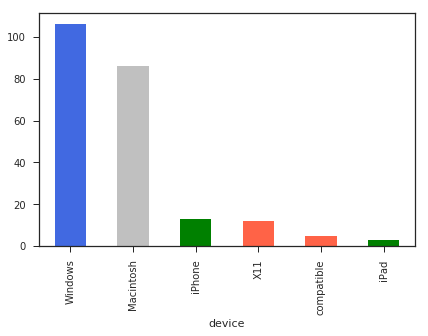

In [92]:
df_device.groupby('device')['userId'].count().sort_values(ascending=False) \
.plot.bar(color=['royalblue','silver','green','tomato','tomato','green']);

Most of users are on Windows system, then the next is on Mac, and it's portable systems. I merge iPhone and iPad into one category because they're relatively lower statistics as well as they are similar in terms of physical devices. Same for X11 and other compatible systems. 

So the rank assignned is 1 for Windows, 2 for Mac, 3 for portabl systems, and 4 for others.

In [93]:
# Encode the categorical variable into numerical according to the rank of its apearing frequency
deviceRank = device.select(['userId','device']) \
            .replace(['Windows','Macintosh','iPhone','iPad','compatible','X11'],['1','2','3','3','4','4'])

deviceRank = deviceRank.withColumn('deviceRank', deviceRank['device'].cast(IntegerType()))

In [94]:
# [Property: location]

# Process the location string and extract only the part of state
stateExtractor = udf(lambda x: x.split(',')[1].split('-')[0]) 

state = dfspark_valid \
        .select(['userId','location']).dropDuplicates() \
        .withColumn('state', stateExtractor('location'))

In [95]:
# Merge dataFrames
dfspark_persona = gender.join(planScale, on=['userId'], how='inner') \
                        .join(deviceRank, on=['userId'], how='inner') \
                        .join(state, on=['userId'], how='inner')

dfspark_persona.show()

+------+-----+---------+------+----------+---------+------+----------+--------------------+-----+
|userId|churn|downgrade|gender|genderCode|paidScale|device|deviceRank|            location|state|
+------+-----+---------+------+----------+---------+------+----------+--------------------+-----+
|100010|    0|        0|     F|         1|      0.0|     3|         3|Bridgeport-Stamfo...|   CT|
|200002|    0|        0|     M|         0|     0.75|     3|         3|Chicago-Napervill...|   IL|
|   125|    1|        0|     M|         0|      0.0|     2|         2|  Corpus Christi, TX|   TX|
|   124|    0|        0|     F|         1|      1.0|     2|         2|Vineland-Bridgeto...|   NJ|
|    51|    1|        0|     M|         0|      1.0|     1|         1|Lexington-Fayette...|   KY|
|     7|    0|        0|     M|         0|      0.0|     1|         1|Seattle-Tacoma-Be...|   WA|
|    15|    0|        0|     M|         0|      1.0|     1|         1|      Morgantown, WV|   WV|
|    54|    1|      

In [96]:
print("Data Shape = (", dfspark_persona.count(), ",", len(dfspark_persona.columns), ")")

Data Shape = ( 225 , 10 )


In [97]:
dfspark_persona = dfspark_persona.toPandas()
dfspark_persona.to_csv('persona.csv')
dfspark_persona.head()

,userId,churn,downgrade,gender,genderCode,paidScale,device,deviceRank,location,state
0,100010,0,0,F,1,0.00,3,3,"Bridgeport-Stamford-Norwalk, CT",CT
1,200002,0,0,M,0,0.75,3,3,"Chicago-Naperville-Elgin, IL-IN-WI",IL
2,125,1,0,M,0,0.00,2,2,"Corpus Christi, TX",TX
3,124,0,0,F,1,1.00,2,2,"Vineland-Bridgeton, NJ",NJ
4,51,1,0,M,0,1.00,1,1,"Lexington-Fayette, KY",KY


In [98]:
dfspark_persona.groupby(['churn'])['gender'].value_counts()

churn  gender
0      M         89
       F         84
1      M         32
       F         20
Name: gender, dtype: int64

In [99]:
dfspark_persona.groupby(['downgrade'])['gender'].value_counts()

downgrade  gender
0          M         100
           F          76
1          F          28
           M          21
Name: gender, dtype: int64

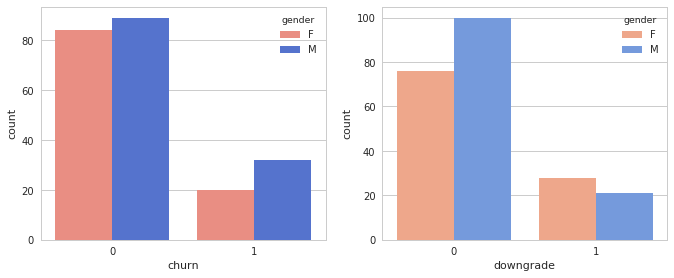

In [100]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1,2, figsize=(10,4))
sns.countplot(x='churn', hue='gender', data=dfspark_persona, palette={"F":"salmon", "M":"royalblue"}, ax=axes[0])
sns.countplot(x='downgrade', hue='gender', data=dfspark_persona, palette={"F":"lightsalmon", "M":"cornflowerblue"}, ax=axes[1]);

There are a bit more male users than female, but overall, the difference is still within statistics uncertainties ($1\sigma$ ~square root of the entries). The dataset doesn't have a big bias in regards to genders (104 female users & 121 male users). 

Left plot: 19% churn rate in females and 26% churn in males are observed. Male churn rate is higher. 

Right plot: We observe that female users downgrade the service more than male users. Up to 27% downgrade rate within females and 17% downgrade within males. 

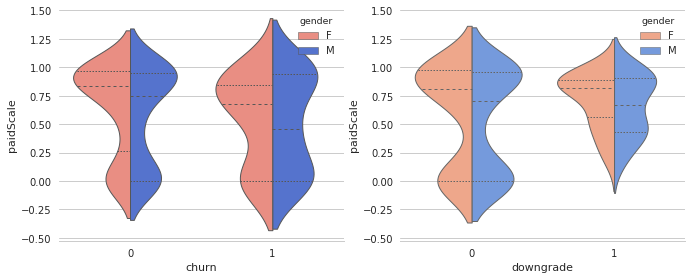

In [101]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

sns.violinplot(data=dfspark_persona, x="churn", y="paidScale", hue="gender",
               split=True, inner="quart", linewidth=1,
               palette={"F":"salmon", "M":"royalblue"}, ax=axes[0])

sns.violinplot(data=dfspark_persona, x="downgrade", y="paidScale", hue="gender",
               split=True, inner="quart", linewidth=1,
               palette={"F":"lightsalmon", "M":"cornflowerblue"}, ax=axes[1])

sns.despine(left=True)


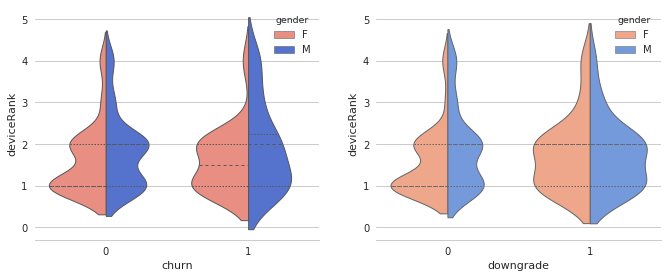

In [102]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

sns.violinplot(data=dfspark_persona, x="churn", y="deviceRank", hue="gender",
               split=True, inner="quart", linewidth=1,
               palette={"F":"salmon", "M":"royalblue"}, ax=axes[0])

sns.violinplot(data=dfspark_persona, x="downgrade", y="deviceRank", hue="gender",
               split=True, inner="quart", linewidth=1,
               palette={"F":"lightsalmon", "M":"cornflowerblue"}, ax=axes[1])


sns.despine(left=True)

In [103]:
# Prepare the drawing DataFrame
df = pd.DataFrame()
df['churn'] = dfspark_persona[dfspark_persona['churn']==1].groupby(['state'])['userId'].count()
df['downgrade'] = dfspark_persona[dfspark_persona['downgrade']==1].groupby(['state'])['userId'].count()
df['all'] = dfspark_persona.groupby(['state'])['userId'].count()
df = df.sort_values(by='all', ascending=False).reset_index().fillna(0)
df

,state,churn,downgrade,all
0,CA,6,12.0,33
1,NY,6,5.0,20
2,TX,3,3.0,16
3,FL,3,5.0,14
4,NC,1,2.0,12
5,IL,2,3.0,10
6,PA,2,3.0,9
7,MO,2,3.0,8
8,AZ,2,1.0,7
9,MI,3,0.0,5


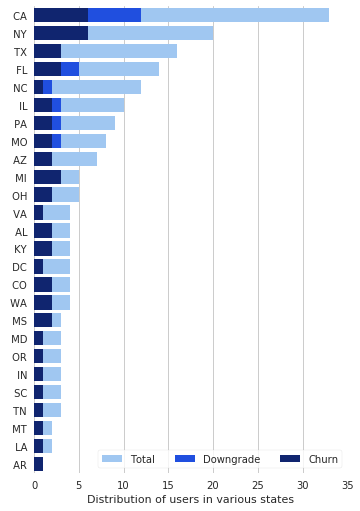

In [104]:
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(5, 8))

# Plot the total users
sns.set_color_codes("pastel")
sns.barplot(x="all", y="state", data=df,
            label="Total", color="b")

# Plot the downgrade users
sns.set_color_codes("bright")
sns.barplot(x="downgrade", y="state", data=df,
            label="Downgrade", color="b")

# Plot the churn users
sns.set_color_codes("dark")
sns.barplot(x="churn", y="state", data=df,
            label="Churn", color="b")

# Add a legend and informative axis label
ax.legend(ncol=3, loc="lower right", frameon=True)
ax.set(xlim=(0, 35), ylabel="",
       xlabel="Distribution of users in various states")
sns.despine(left=True, bottom=True)

In this data set, you can see that California, new york and Texas are the top three states with the largest number of users. And it seems to be in CA, a bigger fraction of users keep using downgrade plans, while in other states, most of the downgrade users tend to cancel the service eventually. 

However, when this small data set is divided into various categories (state), it is not statistical sufficient for many of the states to draw a conclusion. Comparisons divided into states can be more useful when users data grows. 

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Some principles to keep in mind while preparing the processing pipelines on Spark:

- Spark’s query optimizer is called Catalyst. While Catalyst is a powerful tool to turn Python code to an optimized query plan that can run on the JVM, it has some limitations when optimizing your code. It will for example push filters in a particular stage as early as possible in the plan but won’t move a filter across stages. --> So the best is to make that if early filtering is possible without compromising the business logic than you perform this filtering where it’s more appropriate.

- It also can’t decide for you how much data you’re shuffling across the cluster. Remember from the first lesson how expensive sending data through the network is. As much as possible try to avoid shuffling unnecessary data. --> In practice, this means that you need to perform joins and grouped aggregations as late as possible.

- When it comes to joins there is more than one strategy to choose from. If one of your data frames are small consider using broadcast hash join instead of a hash join.

In [2]:
def flag(df):
    # Churn/Downgrade flags
    churn_event = udf(lambda x: 1 if x=='Cancellation Confirmation' else 0, IntegerType())
    downgrade_event = udf(lambda x: 1 if x=='Submit Downgrade' else 0, IntegerType())

    # Remove log that doesn't have userId
    df = df.filter(dfspark['userId'] != '')
    
    df = df \
        .withColumn('churn_event', churn_event('page')) \
        .withColumn('downgrade_event', downgrade_event('page')) 

    windowval = Window.partitionBy('userId')
    df = df \
        .withColumn('churn', max('churn_event').over(windowval)) \
        .withColumn('downgrade', max('downgrade_event').over(windowval))
    
    return df

In [21]:
# Featueres that can be fetched in class `Preprocessor`:

# In function `time`
# 1.firstUseDay: The number of days between registration and first listening to music
# 2.spanUseDay: The number of days between first and the last listening to music
# 3.totDay: The number of days between registration and the last time used
# 4.totUseSession: Total number of sessions used
# 5.avgUseMinute: The average using minutes per session
# 6.stdUseMinute: The standard derivation of using minutes between session for each user
# 7.avgLogsDay: The average logs a user has per day

# In function `page`
# 8.totNextSong: The number of next song played
# 9.totThumbsUp: The number of thumbs up
#10.totThumbsDown: The number of thumbs down
#11.totAddPlaylist: The number of add playlist
#12.totAddFriend: The number of add friends
#13.actsAll and actsPartition: 9+10+11+12 and 9+11+12
#14.maxError: Maximum number of errors encountered in a session 
#15.maxAdvert: Maximum number of Avertisments played in a session

# In function `persona`
#16.genderCode: Gender (encoded)
#17.paidScale: The fraction of paid-logs over the total logs a user has
#18.deviceRank: The device used for playing (encoded)

#19.userID, churn, downgradee

In [134]:
class Preprocessor(object):
    '''
    '''
    
    def __init__(self):
        pass
        
        
    @classmethod
    def time(cls,df):
        
        # check all required columns exist
        required_columns = ["userId","churn","downgrade"]
        assert all([column in df.columns for column in required_columns])
        
        # List of all the attributes:
        lastUse_event = df \
            .select(['userId','churn','downgrade','ts']) \
            .where(df.song.isNotNull()) \
            .groupby(['userId', 'churn', 'downgrade']).agg(max('ts'))

        firstUse_event = df \
            .select(['userId','churn','downgrade','ts']) \
            .where(df.song.isNotNull()) \
            .groupby(['userId', 'churn', 'downgrade']).agg(min('ts'))

        registration_event = df \
            .select(['userId','churn','downgrade','registration']) \
            .groupby(['userId', 'churn', 'downgrade']).agg(min('registration'))
        
        totUseSession = df \
            .select(['userId','churn','downgrade','sessionId']) \
            .groupby(['userId', 'churn', 'downgrade']).agg(countDistinct('sessionId')) \
            .withColumnRenamed('count(DISTINCT sessionId)', 'totUseSession')

        totUseLength = df \
            .select(['userId','churn','downgrade','length']) \
            .groupby(['userId', 'churn', 'downgrade']).agg(sum('length')) \
            .withColumnRenamed('sum(length)', 'totUseLength')
        
        sessionUseLength = df \
            .select(['userId','churn','downgrade','sessionId','length']) \
            .groupby(['userId', 'churn', 'downgrade','sessionId']).agg(sum('length')) \
            .withColumnRenamed('sum(length)', 'sessionUseLength')

        stdUseLength = sessionUseLength \
            .groupby(['userId', 'churn', 'downgrade']).agg(stddev('sessionUseLength')) \
            .withColumnRenamed('stddev_samp(sessionUseLength)', 'stdUseLength')
        
        logs = df \
            .select(['userId','churn','downgrade','ts']) \
            .groupby(['userId', 'churn', 'downgrade']).agg(count('ts')) \
            .withColumnRenamed('count(ts)', 'totLogs')

        
        # [Part 1]: Merge dataFrames for the first 3 attributes
        df_merged = lastUse_event \
            .join(firstUse_event, on=['userId', 'churn', 'downgrade'], how='inner') \
            .join(registration_event, on=['userId', 'churn', 'downgrade'], how='inner')

        # Apply function to convert the timestamps
        time_convertor = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

        df_merged = df_merged \
            .withColumn('lastUse_time', time_convertor('max(ts)')) \
            .withColumn('firstUse_time', time_convertor('min(ts)')) \
            .withColumn('registration_time', time_convertor('min(registration)'))

        df_merged = df_merged \
            .withColumn('firstUseDay', f.datediff(f.col('firstUse_time'), f.col('registration_time'))) \
            .withColumn('spanUseDay', f.datediff(f.col('lastUse_time'), f.col('firstUse_time'))) \
            .withColumn('totDay', f.datediff(f.col('lastUse_time'), f.col('registration_time')))

        df_merged = df_merged.select(['userId','churn','downgrade','firstUseDay','spanUseDay','totDay'])

        # [Part 2]: Merge dataFrames for all the other attributes
        df_merged = df_merged \
            .join(totUseSession, on=['userId', 'churn', 'downgrade'], how='inner') \
            .join(totUseLength, on=['userId', 'churn', 'downgrade'], how='inner') \
            .join(logs, on=['userId', 'churn', 'downgrade'], how='inner') \
            .join(stdUseLength, on=['userId', 'churn', 'downgrade'], how='inner')

        df_merged = df_merged \
            .withColumn('avgUseMinute', round(f.col('totUseLength')/60./f.col('totUseSession')))  \
            .withColumn('avgLogsDay', round(f.col('totLogs')/f.col('totDay'))) \
            .withColumn('stdUseMinute', round(f.col('stdUseLength')/60., 2))
        
        # Fill nan
        df_merged = df_merged.na.fill(value=0, subset=['stdUseMinute','avgLogsDay'])
        
        return df_merged.select(['userId','churn','downgrade',
                                 'firstUseDay','spanUseDay','totDay',
                                 'totUseSession','avgUseMinute','avgLogsDay','stdUseMinute'])
    
    
    @classmethod
    def page(cls,df):
        
        # check all required columns exist
        required_columns = ["userId","churn","downgrade"]
        assert all([column in df.columns for column in required_columns])
        
        # List of all the attributes:
        nextsong = df \
            .select(['userId','churn','downgrade','page']) \
            .where(df.page == 'NextSong') \
            .groupby(['userId','churn','downgrade']).agg(count('page')) \
            .withColumnRenamed('count(page)', 'totNextSong')

        thumbsup = df \
            .select(['userId','churn','downgrade','page']) \
            .where(df.page == 'Thumbs Up') \
            .groupby(['userId','churn','downgrade']).agg(count('page')) \
            .withColumnRenamed('count(page)', 'totThumbsUp')

        thumbsdown = df \
            .select(['userId','churn','downgrade','page']) \
            .where(df.page == 'Thumbs Down') \
            .groupby(['userId','churn','downgrade']).agg(count('page')) \
            .withColumnRenamed('count(page)', 'totThumbsDown')

        add2playlist = df \
            .select(['userId','churn','downgrade','page']) \
            .where(df.page == 'Add to Playlist') \
            .groupby(['userId','churn','downgrade']).agg(count('page')) \
            .withColumnRenamed('count(page)', 'totAddPlaylist')

        addfriend = df \
            .select(['userId','churn','downgrade','page']) \
            .where(df.page == 'Add Friend') \
            .groupby(['userId','churn','downgrade']).agg(count('page')) \
            .withColumnRenamed('count(page)', 'totAddFriend')
        
        error = df \
            .select(['userId','churn','downgrade','page','sessionId']) \
            .where(df.page == 'Error') \
            .groupby(['userId','churn','downgrade','sessionId']).agg(count('page')) \
            .withColumnRenamed('count(page)', 'totError')

        ad = df \
            .select(['userId','churn','downgrade','page','sessionId']) \
            .where(df.page == 'Roll Advert') \
            .groupby(['userId','churn','downgrade','sessionId']).agg(count('page')) \
            .withColumnRenamed('count(page)', 'totAdvert')


        # Merge dataFrames
        # Notice: not every user has each kind of page activities, how='outer'
        # First process the max-ish tolerance relavant activities 
        df_temp = error.join(ad, on=['userId', 'churn', 'downgrade'], how='outer') 
       
        maxerror = df_temp \
                .groupby(['userId','churn','downgrade']).agg(max('totError')) \
                .withColumnRenamed('max(totError)', 'maxError')

        maxad = df_temp \
                .groupby(['userId','churn','downgrade']).agg(max('totAdvert')) \
                .withColumnRenamed('max(totAdvert)', 'maxAdvert')
        
        df_merged = maxerror.join(maxad, on=['userId', 'churn', 'downgrade'], how='outer')
        
        df_merged = df_merged.select(['userId','churn','downgrade','maxError', 'maxAdvert'])
        
        # Keep going on merging other page activities
        df_merged = df_merged \
            .join(nextsong, on=['userId', 'churn', 'downgrade'], how='outer') \
            .join(thumbsup, on=['userId', 'churn', 'downgrade'], how='outer') \
            .join(thumbsdown, on=['userId', 'churn', 'downgrade'], how='outer') \
            .join(add2playlist, on=['userId', 'churn', 'downgrade'], how='outer') \
            .join(addfriend, on=['userId', 'churn', 'downgrade'], how='outer') 
        
        df_merged = df_merged \
            .withColumn('actsAll', f.expr('totThumbsUp + totThumbsDown + totAddPlaylist + totAddFriend')) \
            .withColumn('actsPartition', f.expr('totThumbsUp + totAddPlaylist + totAddFriend'))
        
        # Fill nan
        df_merged = df_merged.na.fill(value=0, subset=['maxError','maxAdvert',
                                                       'totNextSong','totThumbsUp','totThumbsDown',
                                                       'totAddPlaylist','totAddFriend',
                                                       'actsAll', 'actsPartition'])
        
        return df_merged.select(['userId','churn','downgrade',
                                 'maxError', 'maxAdvert',
                                 'totNextSong','totThumbsUp','totThumbsDown','totAddPlaylist','totAddFriend',
                                 'actsAll', 'actsPartition'])
    
        
    @classmethod    
    def persona(cls,df):
        
        # check all required columns exist
        required_columns = ["userId","churn","downgrade"]
        assert all([column in df.columns for column in required_columns])
        
        # List of all the attributes:
        # - gender
        genderCoder = udf(lambda x: 0 if x=='M' else 1, IntegerType())

        gender = df \
            .select(['userId','churn','downgrade','gender']).dropDuplicates() \
            .withColumn('genderCode', genderCoder('gender'))
        
        # - ratio of paid logs
        planCoder = udf(lambda x: 1 if x=='paid' else 0, IntegerType())

        plan = df \
           .select(['userId','level']) \
           .withColumn('plan', planCoder('level'))

        # Define a scalar that takes the ratio of paid-Logs over all of the Logs for a user.
        planScale = plan.groupby(['userId']).agg(round(mean('plan'),2)) \
            .withColumnRenamed('round(avg(plan), 2)', 'paidScale')
        
        # - device using
        deviceExtractor = udf(lambda x: x.split('(')[1].split(')')[0].split(';')[0].split(' ')[0])

        device = df \
            .select(['userId', 'userAgent']).dropDuplicates() \
            .withColumn('device', deviceExtractor('userAgent')) 

        deviceRank = device.select(['userId','device']) \
            .replace(['Windows','Macintosh','iPhone','iPad','compatible','X11'],
                     ['1'      ,'2'        ,'3'     ,'3'   ,'4'         ,'4'])

        deviceRank = deviceRank.withColumn('deviceRank', deviceRank['device'].cast(IntegerType()))
        
        # - location of state
        stateExtractor = udf(lambda x: x.split(',')[1].split('-')[0]) 
        
        state = df \
            .select(['userId','location']).dropDuplicates() \
            .withColumn('state', stateExtractor('location'))

        # Merge dataFrames
        df_merged = gender.join(planScale, on=['userId'], how='inner') \
                        .join(deviceRank, on=['userId'], how='inner') \
                        .join(state, on=['userId'], how='inner')

        return df_merged.select(['userId','churn','downgrade',
                                 'genderCode','paidScale','deviceRank'])

In [ ]:
# Featueres that can be fetched in class `simplePreprocessor`:

# In function `time`
# 1.spanUseDay: The number of days between first and the last listening to music
# 2.sessFluctuation: 'stdUseLength' / ('totUseLength'/'totUseSession'), 
#   The ratio of the standard derivation over the average of used minutes per session

# In function `page`
#3.actsAll: totThumbsUp + totThumbsDown + totAddPlaylist + totAddFriend
#4.maxError: Maximum number of errors encountered in a session 
#5.maxAdvert: Maximum number of Avertisments played in a session

# In function `persona`
#6.genderCode: Gender (encoded)
#7.paidScale: The fraction of paid-logs over the total logs a user has

#8.userID, churn, downgradee

In [14]:
class simplePreprocessor(object):
    '''
    '''
    
    def __init__(self):
        pass
        
        
    @classmethod
    def time(cls,df):
        
        # check all required columns exist
        required_columns = ["userId","churn","downgrade"]
        assert all([column in df.columns for column in required_columns])

        # List of all the attributes:
        df_merged = df \
            .where(df.song.isNotNull()) \
            .groupby(['userId', 'churn', 'downgrade']).agg(max('ts'), min('ts'))
        
        totUse = df \
            .groupby(['userId', 'churn', 'downgrade']) \
            .agg(countDistinct('sessionId').alias('totUseSession'), sum('length').alias('totUseLength')) 
                
        sessionUse = df \
            .groupby(['userId', 'churn', 'downgrade','sessionId']).agg(sum('length').alias('sessionUseLength'))
            
        stdUseLength = sessionUse \
            .groupby(['userId', 'churn', 'downgrade']).agg(stddev('sessionUseLength').alias('stdUseLength'))

        
        # [Part 1]: Merge dataFrames for the first 3 attributes 

        # Apply function to convert the timestamps
        time_convertor = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

        df_merged = df_merged \
            .withColumn('lastUse_time', time_convertor('max(ts)')) \
            .withColumn('firstUse_time', time_convertor('min(ts)')) 

        df_merged = df_merged \
            .withColumn('spanUseDay', f.datediff(f.col('lastUse_time'), f.col('firstUse_time'))) 

        # [Part 2]: Merge dataFrames for all the other attributes
        df_merged = df_merged \
            .join(totUse, on=['userId', 'churn', 'downgrade'], how='inner') \
            .join(stdUseLength, on=['userId', 'churn', 'downgrade'], how='inner') 
        
        df_merged = df_merged \
            .withColumn('sessFluctuation', round(f.col('stdUseLength')/f.col('totUseLength')*f.col('totUseSession'), 2))

        # Fill nan
        df_merged = df_merged.na.fill(value=0, subset=['sessFluctuation'])
    
        return df_merged.select(['userId','churn','downgrade',
                                 'spanUseDay',
                                 'sessFluctuation'])
    
    
    @classmethod
    def page(cls,df):
        
        # check all required columns exist
        required_columns = ["userId","churn","downgrade"]
        assert all([column in df.columns for column in required_columns])
        
        # List of all the attributes:
        thumbsup = df \
            .where(df.page == 'Thumbs Up') \
            .groupby(['userId','churn','downgrade']).agg(count('page').alias('totThumbsUp'))

        thumbsdown = df \
            .where(df.page == 'Thumbs Down') \
            .groupby(['userId','churn','downgrade']).agg(count('page').alias('totThumbsDown'))

        add2playlist = df \
            .where(df.page == 'Add to Playlist') \
            .groupby(['userId','churn','downgrade']).agg(count('page').alias('totAddPlaylist'))

        addfriend = df \
            .where(df.page == 'Add Friend') \
            .groupby(['userId','churn','downgrade']).agg(count('page').alias('totAddFriend'))
        
        error = df \
            .where(df.page == 'Error') \
            .groupby(['userId','churn','downgrade','sessionId']).agg(count('page').alias('totError'))

        ad = df \
            .where(df.page == 'Roll Advert') \
            .groupby(['userId','churn','downgrade','sessionId']).agg(count('page').alias('totAdvert'))
    
        # Merge dataFrames
        # Notice: not every user has each kind of page activities, how='outer'
        # First process the max-ish tolerance relavant activities 
        df_temp = error.join(ad, on=['userId','churn','downgrade'], how='outer') 
       
        df_merged = df_temp \
                    .groupby(['userId','churn','downgrade']) \
                    .agg(max('totError').alias('maxError'), \
                         max('totAdvert').alias('maxAdvert'))
        
        # Keep going on merging other page activities 
        df_merged = df_merged \
            .join(thumbsup, on=['userId', 'churn', 'downgrade'], how='outer') \
            .join(thumbsdown, on=['userId', 'churn', 'downgrade'], how='outer') \
            .join(add2playlist, on=['userId', 'churn', 'downgrade'], how='outer') \
            .join(addfriend, on=['userId', 'churn', 'downgrade'], how='outer') 
        
        df_merged = df_merged \
            .withColumn('actsAll', f.expr('totThumbsUp + totThumbsDown + totAddPlaylist + totAddFriend')) 
        
        # Fill nan
        df_merged = df_merged.na.fill(value=0, subset=['maxError','maxAdvert',
                                                       'actsAll'])
        
        return df_merged.select(['userId','churn','downgrade',
                                 'maxError', 'maxAdvert',
                                 'actsAll'])
    
        
    @classmethod    
    def persona(cls,df):
        
        # check all required columns exist
        required_columns = ["userId","churn","downgrade"]
        assert all([column in df.columns for column in required_columns])
        
        # List of all the attributes:
        # - gender
        genderCoder = udf(lambda x: 0 if x=='M' else 1, IntegerType())

        gender = df \
            .select(['userId','churn','downgrade','gender']).dropDuplicates() \
            .withColumn('genderCode', genderCoder('gender'))
        
        # - ratio of paid logs
        planCoder = udf(lambda x: 1 if x=='paid' else 0, IntegerType())

        plan = df \
           .select(['userId','level']) \
           .withColumn('plan', planCoder('level'))

        # Define a scalar that takes the ratio of paid-Logs over all of the Logs for a user.
        planScale = plan.groupby(['userId']).agg(round(mean('plan'),2).alias('paidScale')) 
        
        # Merge dataFrames
        df_merged = gender.join(planScale, on=['userId'], how='inner') 

        return df_merged.select(['userId','churn','downgrade',
                                 'genderCode','paidScale'])

`totThumbsUp`, `totThumbsDown`, `totAddPlaylist`, `totAddFriend` are highly correlated, we end up adding them together as a variable.

In [ ]:
# Featueres that can be fetched in class `simplestPreprocessor`:

# In function `time`
# 1.spanUseDay: The number of days between first and the last listening to music

# In function `page`
#3.actsAll: totThumbsUp + totThumbsDown + totAddPlaylist + totAddFriend
#4.maxError: Maximum number of errors encountered in a session 
#5.maxAdvert: Maximum number of Avertisments played in a session

#6.userID, churn, downgradee

In [3]:
class simplestPreprocessor(object):
    '''
    '''
    
    def __init__(self):
        pass
        
        
    @classmethod
    def time(cls,df):
        
        # check all required columns exist
        required_columns = ["userId","churn","downgrade"]
        assert all([column in df.columns for column in required_columns])

        # List of all the attributes:
        df_merged = df \
            .where(df.song.isNotNull()) \
            .groupby(['userId', 'churn', 'downgrade']).agg(max('ts'), min('ts'))
        
        # [Part 1]: Merge dataFrames for the first 3 attributes 

        # Apply function to convert the timestamps
        time_convertor = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

        df_merged = df_merged \
            .withColumn('lastUse_time', time_convertor('max(ts)')) \
            .withColumn('firstUse_time', time_convertor('min(ts)')) 

        df_merged = df_merged \
            .withColumn('spanUseDay', f.datediff(f.col('lastUse_time'), f.col('firstUse_time'))) 
    
        return df_merged.select(['userId','churn','downgrade',
                                 'spanUseDay'])
    
    
    @classmethod
    def page(cls,df):
        
        # check all required columns exist
        required_columns = ["userId","churn","downgrade"]
        assert all([column in df.columns for column in required_columns])
        
        # List of all the attributes:
        thumbsup = df \
            .where(df.page == 'Thumbs Up') \
            .groupby(['userId','churn','downgrade']).agg(count('page').alias('totThumbsUp'))

        thumbsdown = df \
            .where(df.page == 'Thumbs Down') \
            .groupby(['userId','churn','downgrade']).agg(count('page').alias('totThumbsDown'))

        add2playlist = df \
            .where(df.page == 'Add to Playlist') \
            .groupby(['userId','churn','downgrade']).agg(count('page').alias('totAddPlaylist'))

        addfriend = df \
            .where(df.page == 'Add Friend') \
            .groupby(['userId','churn','downgrade']).agg(count('page').alias('totAddFriend'))
        
        error = df \
            .where(df.page == 'Error') \
            .groupby(['userId','churn','downgrade','sessionId']).agg(count('page').alias('totError'))

        ad = df \
            .where(df.page == 'Roll Advert') \
            .groupby(['userId','churn','downgrade','sessionId']).agg(count('page').alias('totAdvert'))
    
        # Merge dataFrames
        # Notice: not every user has each kind of page activities, how='outer'
        # First process the max-ish tolerance relavant activities 
        df_temp = error.join(ad, on=['userId','churn','downgrade'], how='outer') 
       
        df_merged = df_temp \
                    .groupby(['userId','churn','downgrade']) \
                    .agg(max('totError').alias('maxError'), \
                         max('totAdvert').alias('maxAdvert'))
        
        # Keep going on merging other page activities 
        df_merged = df_merged \
            .join(thumbsup, on=['userId', 'churn', 'downgrade'], how='outer') \
            .join(thumbsdown, on=['userId', 'churn', 'downgrade'], how='outer') \
            .join(add2playlist, on=['userId', 'churn', 'downgrade'], how='outer') \
            .join(addfriend, on=['userId', 'churn', 'downgrade'], how='outer') 
        
        df_merged = df_merged \
            .withColumn('actsAll', f.expr('totThumbsUp + totThumbsDown + totAddPlaylist + totAddFriend')) 
        
        # Fill nan
        df_merged = df_merged.na.fill(value=0, subset=['maxError','maxAdvert',
                                                       'actsAll'])
        
        return df_merged.select(['userId','churn','downgrade',
                                 'maxError', 'maxAdvert',
                                 'actsAll'])
    

`totThumbsUp`, `totThumbsDown`, `totAddPlaylist`, `totAddFriend` are highly correlated, we end up adding them together as a variable.

In [4]:
# Create a Spark session
spark = SparkSession \
        .builder \
        .appName("Wrangling") \
        .getOrCreate()

# Read-in the data file
path = "mini_sparkify_event_data.json"
dfspark = spark.read.json(path)

# Tag the churn flags over logs
dfspark_valid = flag(dfspark)

In [15]:
p = simplePreprocessor()

# Prepare the time-related features
df_time = p.time(dfspark_valid)

# Prepare the page-related features
df_page = p.page(dfspark_valid)

# Prepare the user profile-related features
df_persona = p.persona(dfspark_valid)

# Merge all the features 
df_model = df_time \
            .join(df_page, on=['userId','churn','downgrade'], how='outer')  \
            .join(df_persona, on=['userId','churn','downgrade'], how='outer') 

# Fill nan
df_model = df_model.na.fill(0)

df_model = df_model.drop('userId')    
df_model = df_model.withColumnRenamed("churn","label")

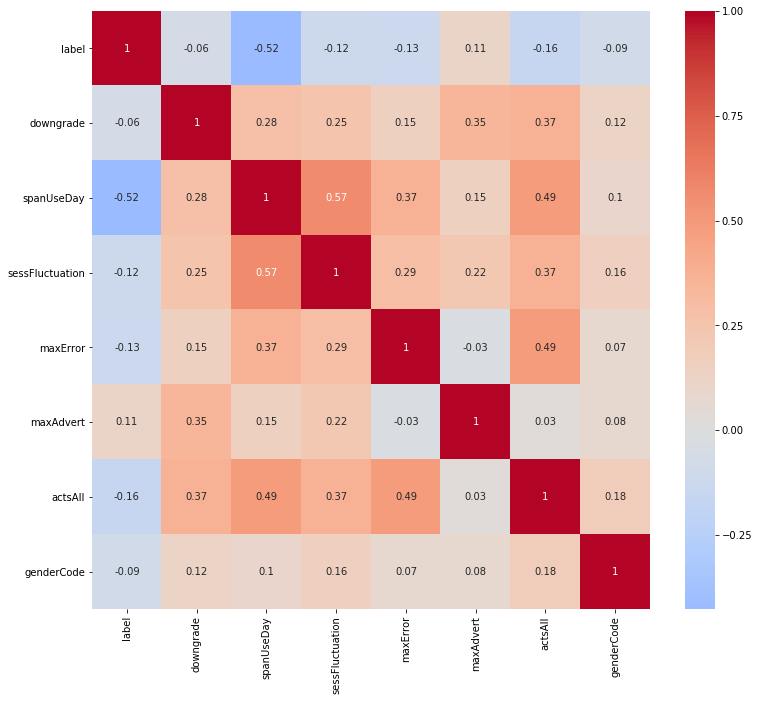

In [16]:
feature_to_use = [feature.name for feature in df_model.schema.fields]

corr = df_model.toPandas()[feature_to_use].corr().round(2)

fig, ax = plt.subplots(figsize=(12.5, 11))
sns.heatmap(data=corr, annot=True, cmap="coolwarm", robust=True, center=0);

#### `Preprocessor()` and `simplePreprocessor()` takes too much time running on the workspace, we go for `simplestPreprocessor()` that takes only a few selected features but it should be sufficient for the first iteration of modeling.

In [5]:
p = simplestPreprocessor()

# Prepare the time-related features
df_time = p.time(dfspark_valid)

# Prepare the page-related features
df_page = p.page(dfspark_valid)

# Merge all the features 
df_model = df_time \
            .join(df_page, on=['userId','churn','downgrade'], how='outer')

# Fill nan
df_model = df_model.na.fill(0)

df_model = df_model.drop('userId')    
df_model = df_model.withColumnRenamed("churn","label")

['label', 'downgrade', 'spanUseDay', 'maxError', 'maxAdvert', 'actsAll']


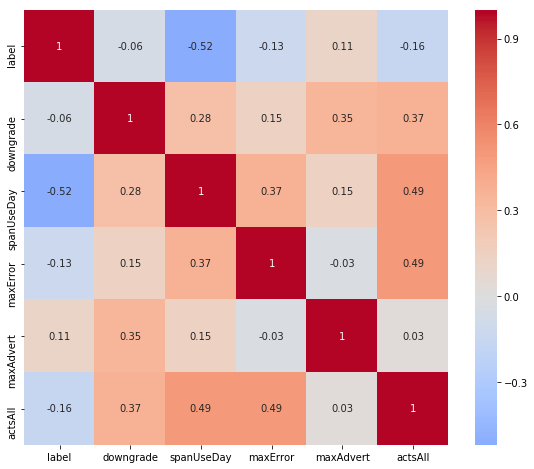

In [6]:
feature_to_use = [feature.name for feature in df_model.schema.fields]
print(feature_to_use)

corr = df_model.toPandas()[feature_to_use].corr().round(2)

fig, ax = plt.subplots(figsize=(9.5, 8))
sns.heatmap(data=corr, annot=True, cmap="coolwarm", robust=True, center=0);

In [7]:
df_model.printSchema()
df_model.toPandas().shape

root
 |-- label: integer (nullable = true)
 |-- downgrade: integer (nullable = true)
 |-- spanUseDay: integer (nullable = true)
 |-- maxError: long (nullable = true)
 |-- maxAdvert: long (nullable = true)
 |-- actsAll: long (nullable = true)



(225, 6)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

As the data set used is small, we will allocate the training/development/test sets in a common way at a ratio of 60/20/20%. 

In [9]:
from time import time

In [11]:
def logesticRegressor(train, validation):
    # initialize classifier, set evaluater and build paramGrid
    lr = LogisticRegression(maxIter=10)
    f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
    paramGrid = ParamGridBuilder().build()
    crossval_lr = CrossValidator(estimator=lr, evaluator=f1_evaluator, estimatorParamMaps=paramGrid, numFolds=3)

    # Calculate time metric of model. 
    start_time = time()
    cvModel_lr = crossval_lr.fit(train)
    end_time = time()
    cvModel_lr.avgMetrics
    seconds = end_time - start_time

    results_lr = cvModel_lr.transform(validation)

    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

    print('Logistic Regression Metrics:')
    print('Accuracy of model is : {}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "accuracy"})))
    print('F1 score of model is :{}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "f1"})))
    print('The training process of model took {} seconds'.format(seconds))

In [12]:
def randomforestClassifer(train, validation):
    # initialize classifier, set evaluater and build paramGrid
    rf = RandomForestClassifier()
    f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
    paramGrid = ParamGridBuilder().build()
    crossval_rf = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=f1_evaluator, numFolds=3)

    # Calculate time metric of model. 
    start_time = time()
    cvModel_rf = crossval_rf.fit(train)
    end_time = time()
    cvModel_rf.avgMetrics
    seconds = end_time- start_time

    results_rf = cvModel_rf.transform(validation)

    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

    print('Random Forest Metrics:')
    print('Accuracy of model is : {}'.format(evaluator.evaluate(results_rf, {evaluator.metricName: "accuracy"})))
    print('F1 score of model is :{}'.format(evaluator.evaluate(results_rf, {evaluator.metricName: "f1"})))
    print('The training process of model took {} seconds'.format(seconds))

In [13]:
def gbtClassifier(train, validation):
    # initialize classifier, set evaluater and build paramGrid
    gbt = GBTClassifier(maxIter=10,seed=42)
    f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
    paramGrid = ParamGridBuilder().build()
    crossval_gbt = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=f1_evaluator, numFolds=3)

    # Calculate time metric of model. 
    start_time = time()
    cvModel_gbt = crossval_gbt.fit(train)
    end_time = time()
    cvModel_gbt.avgMetrics
    seconds = end_time- start_time

    results_gbt = cvModel_gbt.transform(validation)

    evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

    print('Gradient Boosted Trees Metrics:')
    print('Accuracy of model is : {}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "accuracy"})))
    print('F1 score of model is :{}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "f1"})))
    print('The training process of model took {} seconds'.format(seconds))

In [10]:
def transformer(df, feature_to_use):
    assembler = VectorAssembler(inputCols=feature_to_use, outputCol="num_features")
    df = assembler.transform(df)

    # using standard scaler
    scaler = StandardScaler(inputCol="num_features", outputCol="features", withStd=True)
    
    return scaler.fit(df).transform(df)

In [8]:
def train_test_split(df):
    '''
    '''
    train, rest = df.randomSplit([0.6, 0.4], seed=42)
    dev, test = rest.randomSplit([0.5, 0.5], seed=42)
    
    return train, dev, test

### First glimpse of the model performace:
with parts of selected variables using default parameters setting

In [129]:
feature_to_use = ['downgrade',
                  'spanUseDay', 
                  'maxError', 'maxAdvert', 
                  'actsAll']

train, validation, test = train_test_split(transformer(df_model, feature_to_use))

In [54]:
logesticRegressor(train, validation)

Logistic Regression Metrics:
Accuracy of model is : 0.85
F1 score of model is :0.8373040752351096
The training process of model took 472.6508414745331 seconds


In [57]:
randomforestClassifer(train, validation)

Random Forest Metrics:
Accuracy of model is : 0.7
F1 score of model is :0.6156250000000001
The training process of model took 561.9653441905975 seconds


In [60]:
gbtClassifier(train, validation)

Gradient Boosted Trees Metrics:
Accuracy of model is : 0.7
F1 score of model is :0.6600000000000001
The training process of model took 889.3813717365265 seconds


`GBTClassifier` takes much more time than the other two, and the performance is not far better. So at this stage, we will not adopt it. 

Given the performance derived from `LogisticRegression` and `RandomForestClassifier` is in a similar order, we will go with these two and do a little of hyperparmeters tunning.  

### Hyper-parmeters tunning

In [20]:
# Optimizing Hyperparameters in Random Forest Classification
clf = LogisticRegression()
paramGrid = ParamGridBuilder() \
            .addGrid(clf.regParam, [0.05, 0.1, 0.2]) \
            .addGrid(clf.maxIter, [5, 10, 15]) \
            .build()

crossval = CrossValidator(estimator = Pipeline(stages=[clf]),
                         estimatorParamMaps = paramGrid,
                         evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                         numFolds = 3)

cvModel_lr = crossval.fit(train)
predictions = cvModel_lr.transform(test)

evaluator = MulticlassClassificationEvaluator(metricName='f1')
f1_score = evaluator.evaluate(predictions.select(col('label'), col('prediction')))
print('Accuracy of model is :  {}'.format(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})))
print('The F1 score is {:.2%}'.format(f1_score)) 
   
bestPipeline = cvModel_lr.bestModel

print('Best parameters : max iter:{}, reg param:{}, '.format(bestPipeline.stages[0].getOrDefault('maxIter'), bestPipeline.stages[0].getOrDefault('regParam')))

The F1 score is 70.01%
Best parameters : max iter:5, elasticNet:0.05, 


In [15]:
# Best Model: Random Forrest Model with max depth:10, num Trees:20 parameters
lr_best = LogisticRegression(maxIter=5, elasticNetParam=0.05)
lr_best_model = lr_best.fit(train)
result = lr_best_model.transform(test)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Random Forrest Model - Test Metrics with best parameters:')
print('Accuracy of model is :  {}'.format(evaluator.evaluate(result, {evaluator.metricName: "accuracy"})))
print('F1 score of model is : {}'.format(evaluator.evaluate(result, {evaluator.metricName: "f1"})))

Random Forrest Model - Test Metrics with best parameters:
Accuracy of model is :  0.7571428571428571
F1 score of model is : 0.7126469073371727


In [13]:
# Optimizing Hyperparameters in Random Forest Classification
clf = RandomForestClassifier()
paramGrid = ParamGridBuilder() \
        .addGrid(clf.maxDepth, [5, 10, 15]) \
        .addGrid(clf.numTrees, [20, 30, 40, 50]) \
        .build()

crossval = CrossValidator(estimator = Pipeline(stages=[clf]),
                         estimatorParamMaps = paramGrid,
                         evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                         numFolds = 3)

cvModel_rf = crossval.fit(train)
predictions = cvModel_rf.transform(test)

evaluator = MulticlassClassificationEvaluator(metricName='f1')
f1_score = evaluator.evaluate(predictions.select(col('label'), col('prediction')))
print('Accuracy of model is :  {}'.format(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})))
print('The F1 score is {:.2%}'.format(f1_score)) 
   
bestPipeline = cvModel_rf.bestModel

print('Best parameters : max depth:{}, num Trees:{}'.format(bestPipeline.stages[0].getOrDefault('maxDepth'), bestPipeline.stages[0].getNumTrees))

The F1 score is 75.57%
Best parameters : max depth:10, num Trees:40


In [14]:
# Best Model: Random Forrest Model with max depth:10, num Trees:20 parameters
rf_best = RandomForestClassifier(maxDepth=10, numTrees=40)
rf_best_model = rf_best.fit(train)
result = rf_best_model.transform(test)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Random Forrest Model - Test Metrics with best parameters:')
print('Accuracy of model is :  {}'.format(evaluator.evaluate(result, {evaluator.metricName: "accuracy"})))
print('F1 score of model is : {}'.format(evaluator.evaluate(result, {evaluator.metricName: "f1"})))

Random Forrest Model - Test Metrics with best parameters:
Accuracy of model is :  0.7857142857142857
F1 score of model is : 0.7556916522433763


## Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

## Result and potential improvement:

For this data set, we can use Random Forest as the classifier and it achieves a 0.76 F1-score with 5 features in modeling.

The next we should do is to look at the mis-tag part, ie. False Positive and False Negative, to see if a kind of natural 'ceiling' is reached. And to see if the achieved predicting power is sufficiently enough for our problem setting. We may need several iterations until we finally adopt a model on operation at the state of the time. Then, as the number of data increases, it is necessary to update the model from time to time.

It also has some space for improvement in the next iteration:
- Adding more features into the model. We have already seen some of them in the section of EAD, and we can also further explore some temporal features, for example: the usage over the last n days for each user.
- Adopted the above item, and try with other algorithms. Sometimes, some algorithms will perform better when more features are included in the model. Of course, the time needed for modelling will grow significantly longer with more variables.
- Redefine the analysis as a multi-class classification problem such as the categories shown in the pie chart. This only applies to bigger data, when the smallest group also has enough statistics.

## Summary

We make the churn study using a subset of customer data, with the pipelines for feature engineering and modeling by pySpark, which also gives us the flexibility to extend the framework to big data analysis. Then we check whether this data can represent most users. 

Later, we looked through many features (also made some) and selected some used for modelling. With cross-validation and hyper-parameters scanned applied on each of the algorithms, an F1-score of 0.76 is derived when using Random Forest method to predict the customer churn. This is the baseline prediction, and the predicting power can be improved by implementing more features in the model or applying the analysis with a larger data set.

Hope you find this interesting.